# Project: Relationship between broadband accessibility and socioeconomic factors

## Content
- [Project Overview](#project-overview)
- [Read and visualize input dataset](#read-and-visualize-input-dataset)
    - [Read cartographic boundary files](#read-cartographic-boundary-files)
    - [Visualize 5G coverage](#visualize-5g-coverage)
    - [Visualize median household income](#visualize-median-household-income)
    - [Visualize education attainment](#visualize-education-attainment)
    - [Visualize population density](#visualize-population-density)
- [Analysis](#analysis)
    - [Relationship between 5G coverage and Median household income](#5g-coverage-and-median-household-income)
    - [Relationship between 5G coverage and Education attainment](#5g-coverage-and-education-attainment)
    - [Relationship between 5G coverage and Population density](#5g-coverage-and-population-density)
- [Conclusion](#conclusion)

<a id='project-overview'></a>
## Project Overview

Broadband connectivity is widely recognized as an important infrastructure that supports education, economic development, telehealth, and civic participation. Due to rapid innovations, broadband technologies have developed from 3G and 4G to 5G, which now offers transformative speed to perform more challenging tasks such as autonomous driving, augmented/virtual reality, etc. Despite steady national improvements in broadband adoption, significant disparities exist along socioeconomic lines.

Therefore, this project aims to study how 5G mobile broadband accessibility varies across the U.S. in relation to key socioeconomic factors including income, education level, and population density, in order to better understand the digital divide. It integrates 5G coverage data from FCC National Broadband Map with demographic and socioeconomic datasets from American Community Survey to identify areas where advanced broadband services are lacking and analyze the implications for social and economic equity. The analysis is conducted on a county level because of data availability and the amount of details it provides with an area unit smaller than the states.

To set up a clear direction for the project, here are the questions that I aim to answer and my hypotheses:
1. <b>Question</b>: How does high-speed broadband coverage correlate with median income? <br/>
   <b>Hypothesis</b>: High-speed broadband coverage is highly and positively correlated with median income in a county.

2. <b>Question</b>: What is the relationship between education attainment and high-speed broadband coverage? <br/>
   <b>Hypothesis</b>: The higher the education attained by the population in a county, the higher the percentage of high-speed broadband coverage.
   
3. <b>Question</b>: Is there a correlation population density and broadband coverage? <br/>
   <b>Hypothesis</b>: Yes, population density in a county is highly and positively correlated with broadband coverage.

<a id='read-and-visualize-input-dataset'></a>
## Read and visualize input dataset

This section includes data preprocessing and integration, and exploratory data analysis such as statistical summary (mean, median, standard deviation, outliers) and simple plots to study the spatial patterns of the datasets.

#### Data sources
- FCC National Broadband Map, https://broadbandmap.fcc.gov/data-download/nationwide-data?version=jun2024
- United States Census Bureau (American Community Survey), https://data.census.gov/table
    - Table DP05 ACS Demographic and Housing Estimates
    - Table S1501 Educational Attainment
    - Table S1901 Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)
- United States Census Bureau -- Cartographic Boundary Files, https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

<a id='read-cartographic-boundary-files'></a>
### Read cartographic boundary files

In [364]:
from geopandas import gpd
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [288]:
# read the cartographic boundary file that contains county information
geom = gpd.read_file('./county/cb_2018_us_county_20m.shp')

# convert string to int
geom['STATEFP'] = geom['STATEFP'].astype(int)

# reference for FIPS code: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt
# remove Puerto Rico
geom = geom[geom['STATEFP'] <= 56] 

# remove Alaska
# geom = geom[geom['STATEFP'] != 2] 

# remove Hawaii
# geom = geom[geom['STATEFP'] != 15]

geom.sort_values(by='STATEFP')

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
1972,1,013,00161532,0500000US01013,01013,Butler,06,2012002530,2701198,"POLYGON ((-86.90894 31.96167, -86.85758 31.962..."
1429,1,055,00161553,0500000US01055,01055,Etowah,06,1386373604,34568854,"POLYGON ((-86.33239 34.04050, -86.30352 34.099..."
2302,1,099,00161576,0500000US01099,01099,Monroe,06,2656469661,22609681,"POLYGON ((-87.78480 31.32467, -87.66557 31.423..."
453,1,045,00161548,0500000US01045,01045,Dale,06,1453244553,4082940,"POLYGON ((-85.78914 31.61796, -85.74825 31.618..."
66,1,075,00161563,0500000US01075,01075,Lamar,06,1566544637,1600679,"POLYGON ((-88.25444 33.69878, -88.24839 33.744..."
...,...,...,...,...,...,...,...,...,...,...
2341,56,003,01605067,0500000US56003,56003,Big Horn,06,8124681754,55228616,"POLYGON ((-108.62149 44.99968, -108.50068 44.9..."
2950,56,015,01605073,0500000US56015,56015,Goshen,06,5764311418,16969240,"POLYGON ((-104.65564 42.60947, -104.05266 42.6..."
1339,56,029,01605079,0500000US56029,56029,Park,06,17972027696,67638740,"POLYGON ((-111.05689 44.86666, -111.04432 45.0..."
2223,56,021,01605075,0500000US56021,56021,Laramie,06,6956354965,4348083,"POLYGON ((-105.27824 41.65666, -104.65334 41.6..."


In [289]:
# get the epsg of the dataset geometry
geom.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [17]:
geom.geometry.total_bounds

array([-179.174265,   18.917466,  179.773922,   71.352561])

<Axes: >

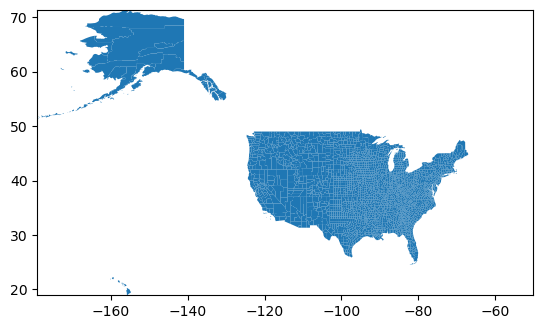

In [18]:
fig, ax = plt.subplots()

# remove small parts of Alaska on the far right for clearer visualization
ax.set_xlim(geom.geometry.total_bounds[0], -50)
ax.set_ylim(geom.geometry.total_bounds[1], geom.geometry.total_bounds[3])

geom.plot(ax=ax)

<a id='visualize-5g-coverage'></a>
### Spatially visualize the availability of 5G mobile broadband services in the United States

In [58]:
# reads the csv file that contains 5G mobile broadband information
mb = pd.read_csv('MB/bdc_us_mobile_broadband_summary_by_geography_J24_04feb2025.csv')

# selects data on a county level
mb = mb[mb['geography_type'] == 'County']
mb = mb[mb['area_data_type'] == 'Total']

# rename columns for more convenient merge later
mb = mb.rename(columns={'geography_id': 'GEOID'})

mb.head()

,area_data_type,geography_type,GEOID,geography_desc,total_area,mobilebb_3g_area_st_pct,mobilebb_3g_area_iv_pct,mobilebb_4g_area_st_pct,mobilebb_4g_area_iv_pct,mobilebb_5g_spd1_area_st_pct,mobilebb_5g_spd1_area_iv_pct,mobilebb_5g_spd2_area_st_pct,mobilebb_5g_spd2_area_iv_pct
57,Total,County,01001,"Autauga, AL",1579.9875,0.0,0.0,0.9954,0.6587,0.8271,0.3187,0.5996,0.1966
58,Total,County,01003,"Baldwin, AL",5165.7165,0.0,0.0,0.9249,0.6883,0.6890,0.4264,0.5556,0.3341
59,Total,County,01005,"Barbour, AL",2407.0583,0.0,0.0,0.9513,0.5549,0.3320,0.0769,0.1886,0.0438
60,Total,County,01007,"Bibb, AL",1630.2311,0.0,0.0,0.9665,0.5325,0.4569,0.0963,0.2634,0.0524
61,Total,County,01009,"Blount, AL",1720.1851,0.0,0.0,0.9991,0.8726,0.9378,0.6208,0.6752,0.4182


In [59]:
# merge geom df with mb dataframe by the attribute GEOID
plt_mb = geom.merge(mb, on='GEOID')

# selects columns GEOID, country name, geometry, and percentage of county's area with 5G mobile broadband available
plt_mb = plt_mb[['GEOID', 'geography_desc', 'geometry', 'mobilebb_5g_spd1_area_st_pct']]

plt_mb = plt_mb.rename(columns={'mobilebb_5g_spd1_area_st_pct': '5g_pct'})

plt_mb.head()

,GEOID,geography_desc,geometry,5g_pct
0,37017,"Bladen, NC","POLYGON ((-78.90200 34.83527, -78.79960 34.850...",0.5394
1,37167,"Stanly, NC","POLYGON ((-80.49737 35.20210, -80.29542 35.502...",0.9249
2,39153,"Summit, OH","POLYGON ((-81.68699 41.13596, -81.68495 41.277...",1.0000
3,42113,"Sullivan, PA","POLYGON ((-76.81373 41.59003, -76.22014 41.541...",0.3278
4,48459,"Upshur, TX","POLYGON ((-95.15274 32.66095, -95.15211 32.902...",0.7230


In [297]:
plt_mb[['5g_pct']].describe()

,5g_pct
count,3141.000000
mean,0.676043
std,0.246265
min,0.000000
25%,0.505400
50%,0.716000
75%,0.889900
max,1.000000


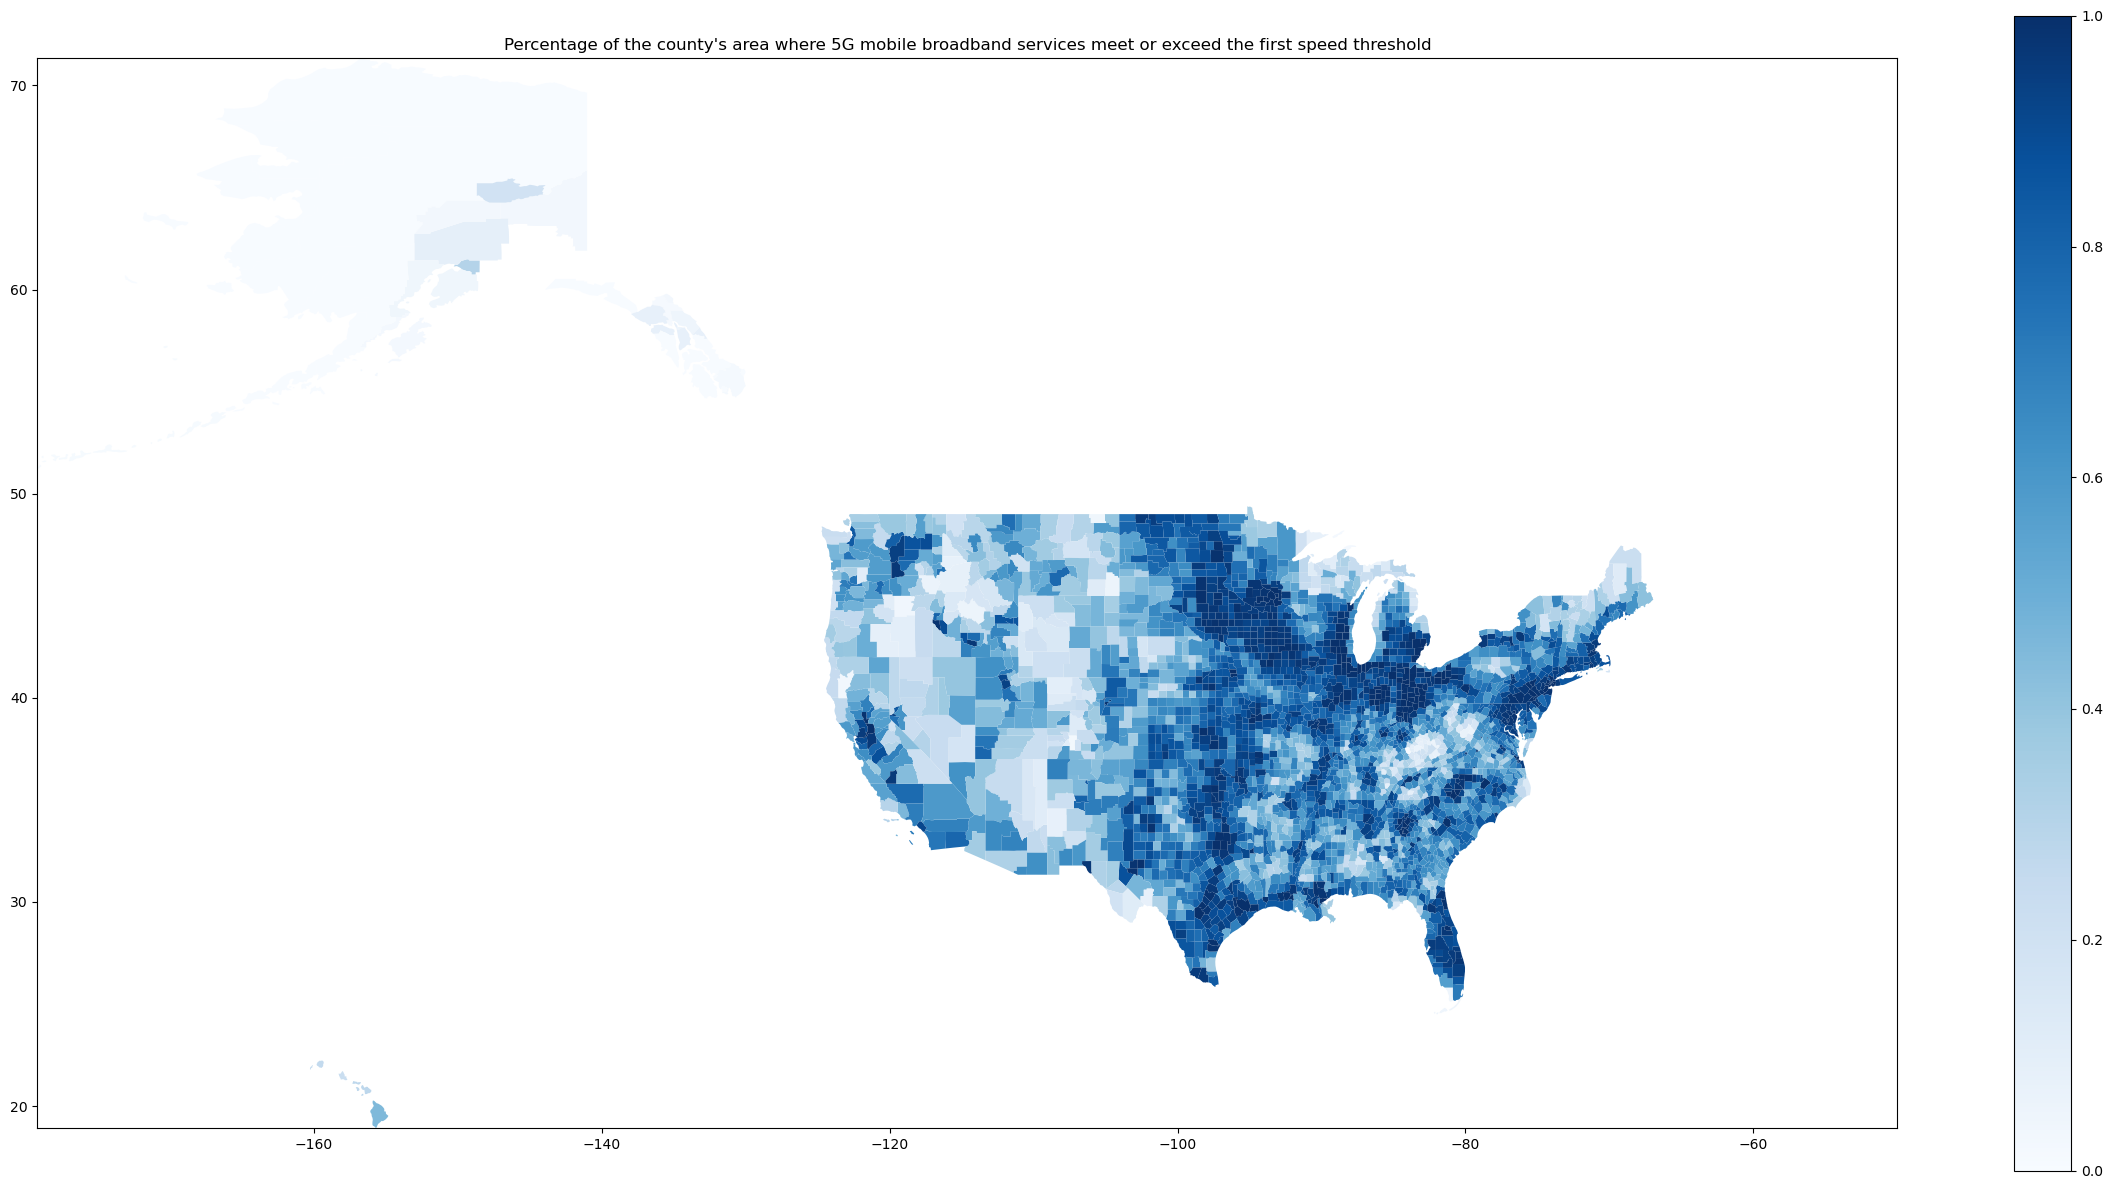

In [220]:
fig, ax = plt.subplots(figsize=(30,15))

# remove small parts of Alaska on the far right for clearer visualization
minx, miny, maxx, maxy = plt_mb.geometry.total_bounds
ax.set_xlim(minx, -50) 
ax.set_ylim(miny, maxy)

# # remove Alaska
# ax.set_xlim(-130, -60)
# ax.set_ylim(20, 50)

plt_mb.plot(ax=ax, column='5g_pct', cmap='Blues', legend=True)
ax.set_title("Percentage of the county's area where 5G mobile broadband services meet or exceed the first speed threshold")
plt.show()

<a id='visualize-median-household-income'></a>
### Spatially visualize median household income in the United States

In [290]:
# use geoid to join two dataframes
# s1901 income data -- C01: households; 012E: median income estimate

In [304]:
# reads csv file for median household income
income = pd.read_csv('acs/ACSST5Y2023.S1901-Data.csv')

# remove column names
income = income[1:]

# selects columns GEOID, county name, and median household income
income = income[['GEO_ID', 'NAME', 'S1901_C01_012E']]

income.head()

,GEO_ID,NAME,S1901_C01_012E
1,0500000US01001,"Autauga County, Alabama",69841
2,0500000US01003,"Baldwin County, Alabama",75019
3,0500000US01005,"Barbour County, Alabama",44290
4,0500000US01007,"Bibb County, Alabama",51215
5,0500000US01009,"Blount County, Alabama",61096


In [305]:
# slices the last five digits of GEOID; this is necessary for df merge
income['GEO_ID'] = income['GEO_ID'].str.slice(-5)

# rename columns for more convenient merge
income = income.rename(columns={'GEO_ID': 'GEOID', 'S1901_C01_012E': 'income'})

# convert income from string to numbers
income['income'] = pd.to_numeric(income['income'], errors='coerce')

income.head()

,GEOID,NAME,income
1,01001,"Autauga County, Alabama",69841.0
2,01003,"Baldwin County, Alabama",75019.0
3,01005,"Barbour County, Alabama",44290.0
4,01007,"Bibb County, Alabama",51215.0
5,01009,"Blount County, Alabama",61096.0


In [306]:
# merge geom df with income df by the attribute GEOID
plt_income = geom.merge(income, on='GEOID')
plt_income = plt_income[['STATEFP', 'COUNTYFP', 'geometry', 'income']]
plt_income.head()

,STATEFP,COUNTYFP,geometry,income
0,37,017,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",44528.0
1,37,167,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",61631.0
2,39,153,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",71016.0
3,42,113,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",64758.0
4,48,459,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",62794.0


In [307]:
plt_income[['income']].describe()

,income
count,3131.000000
mean,65984.760141
std,17338.930344
min,25425.000000
25%,54953.000000
50%,63625.000000
75%,73408.500000
max,178707.000000


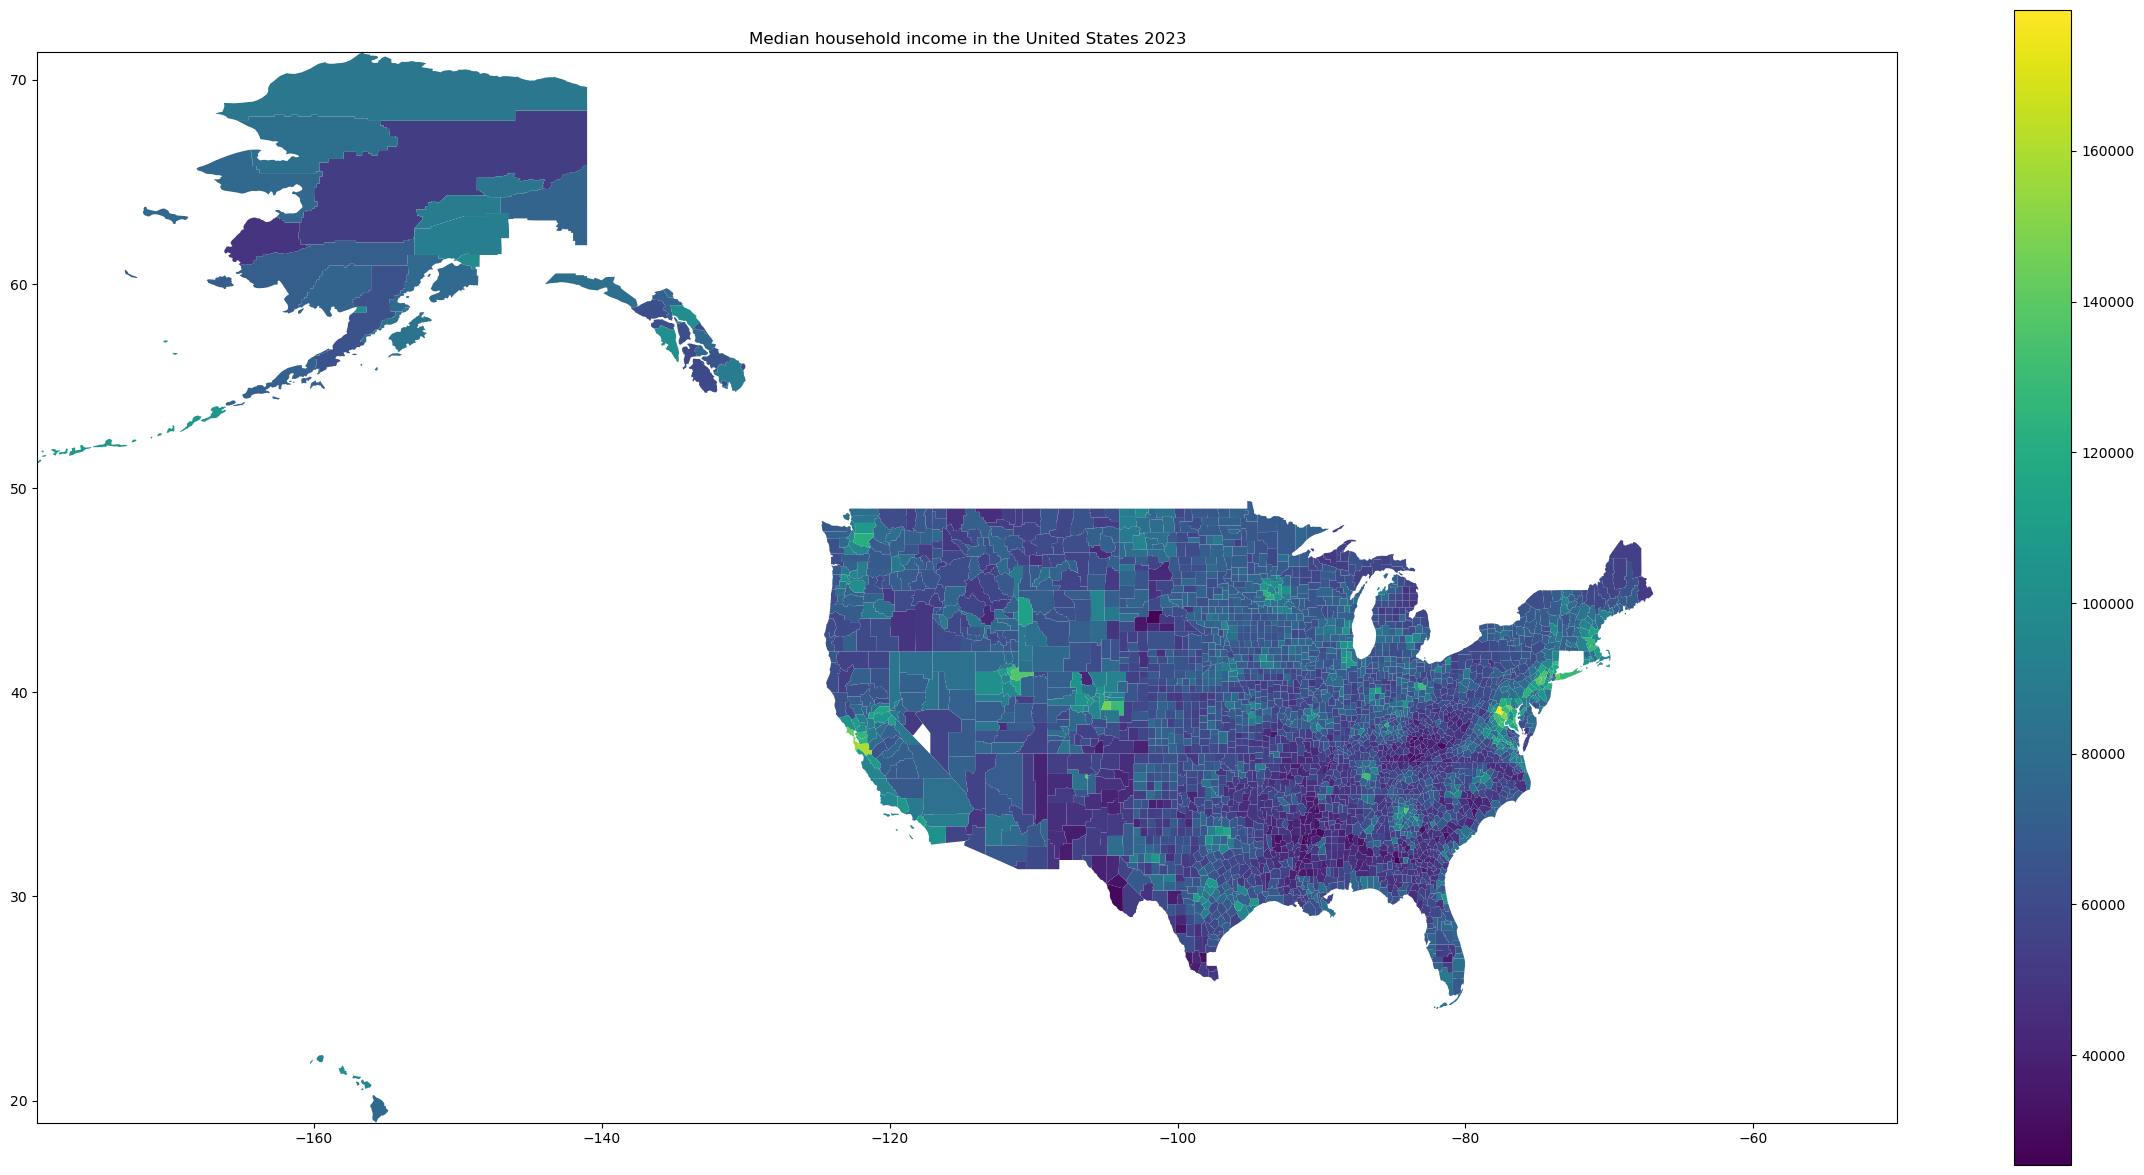

In [316]:
fig, ax = plt.subplots(figsize=(30,15))

minx, miny, maxx, maxy = plt_income.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

# ax.set_xlim(-130, -60)
# ax.set_ylim(20, 50)

plt_income.plot(ax=ax, column='income', legend=True)
ax.set_title('Median household income in the United States 2023')
plt.show()

<a id='visualize-education-attainment'></a>
### Spatially visualize education attainment

In [309]:
# use geoid to join two dataframes
# s1501 education data -- C02: percentage; 015E: population 25 years old and above, bachelor's degree or higher

In [310]:
# reads csv file for education attainment
educ = pd.read_csv('acs/ACSST5Y2023.S1501-Data.csv')

# remove column names
educ = educ[1:]

# selects columns GEOID, county name, and bachelor's degree
educ = educ[['GEO_ID', 'NAME', 'S1501_C02_015E']]

educ.head()

/tmp/ipykernel_377/1047621194.py:2: DtypeWarning: Columns (2,4,5,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,40,41,42,43,44,46,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,106,107,108,109,118,119,122,123,124,125,126,127,132,133,134,135,136,137,138,139,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,162,163,164,165,168,169,170,171,174,175,176,177,180,181,182,183,186,187,188,189,192,193,194,195,228,229,230,231,234,235,236,237,238,239,240,241,242,243,244,245,258,260,261,262,263,264,265,266,267,268,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,290,291,292,293,294,296,297,298,299,300,302,303,304,305,306,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,

,GEO_ID,NAME,S1501_C02_015E
1,0500000US01001,"Autauga County, Alabama",28.3
2,0500000US01003,"Baldwin County, Alabama",32.8
3,0500000US01005,"Barbour County, Alabama",11.5
4,0500000US01007,"Bibb County, Alabama",11.5
5,0500000US01009,"Blount County, Alabama",15.6


In [311]:
# slices the last five digits of GEOID; this is necessary for df merge
educ['GEO_ID'] = educ['GEO_ID'].str.slice(-5)

# rename columns for more convenient merge
educ = educ.rename(columns={'GEO_ID': 'GEOID', 'S1501_C02_015E': 'bs25_pct'})

# convert percentage from string to numbers
educ['bs25_pct'] = pd.to_numeric(educ['bs25_pct'], errors='coerce')

educ.head()

,GEOID,NAME,bs25_pct
1,01001,"Autauga County, Alabama",28.3
2,01003,"Baldwin County, Alabama",32.8
3,01005,"Barbour County, Alabama",11.5
4,01007,"Bibb County, Alabama",11.5
5,01009,"Blount County, Alabama",15.6


In [312]:
# merge geom df with income df by the attribute GEOID
plt_educ = geom.merge(educ, on='GEOID')
plt_educ = plt_educ[['STATEFP', 'COUNTYFP', 'geometry', 'bs25_pct']]
plt_educ.head()

,STATEFP,COUNTYFP,geometry,bs25_pct
0,37,017,"POLYGON ((-78.90200 34.83527, -78.79960 34.850...",20.6
1,37,167,"POLYGON ((-80.49737 35.20210, -80.29542 35.502...",19.7
2,39,153,"POLYGON ((-81.68699 41.13596, -81.68495 41.277...",35.3
3,42,113,"POLYGON ((-76.81373 41.59003, -76.22014 41.541...",19.7
4,48,459,"POLYGON ((-95.15274 32.66095, -95.15211 32.902...",17.5


In [313]:
plt_educ[['bs25_pct']].describe()

,bs25_pct
count,3133.000000
mean,24.036610
std,10.161749
min,0.000000
25%,17.000000
50%,21.400000
75%,28.600000
max,79.700000


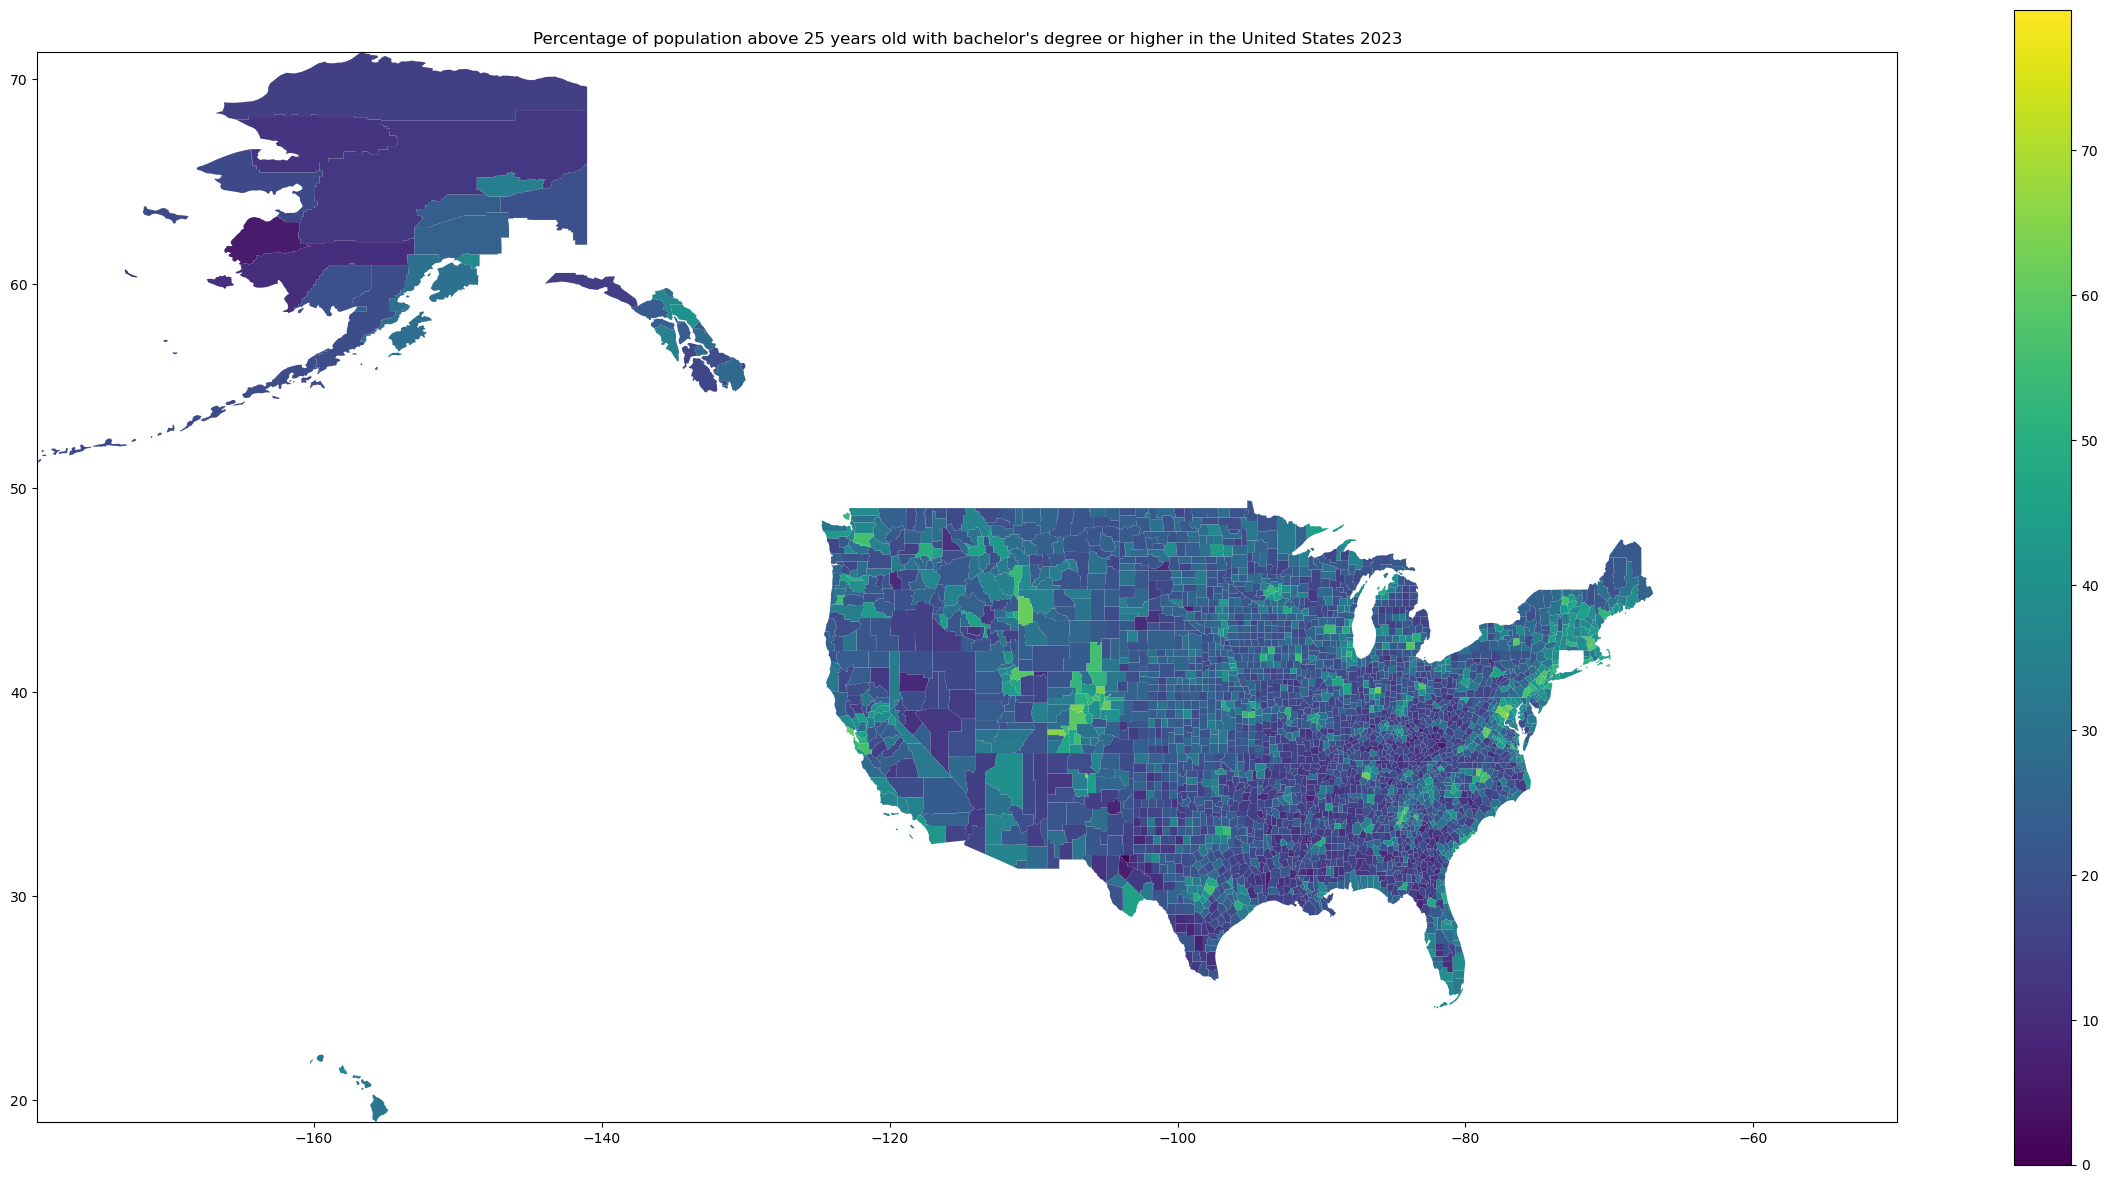

In [315]:
fig, ax = plt.subplots(figsize=(30,15))

minx, miny, maxx, maxy = plt_educ.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

# ax.set_xlim(-130, -60)
# ax.set_ylim(20, 50)

plt_educ.plot(ax=ax, column='bs25_pct', legend=True)
ax.set_title('Percentage of population above 25 years old with bachelor\'s degree or higher in the United States 2023')
plt.show()

<a id='visualize-population-density'></a>
### Spatially visualize population density

In [319]:
# use geoid to join two dataframes
# dp05 education data -- 0001E: Total population
# reads csv file for population
pop = pd.read_csv('acs/ACSDP5Y2023.DP05-Data.csv')

# remove column names
pop = pop[1:]

# selects columns GEOID, county name, and total population estimate
pop = pop[['GEO_ID', 'NAME', 'DP05_0001E']]

pop.head()

/tmp/ipykernel_377/366039935.py:4: DtypeWarning: Columns (2,4,6,8,10,12,13,14,15,16,18,20,22,24,26,27,28,29,30,32,33,34,35,36,37,38,40,41,42,44,45,46,47,48,50,52,54,56,58,60,62,66,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,138,139,140,141,142,143,144,145,146,147,148,149,150,152,154,155,156,157,158,159,160,161,162,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,192,194,198,200,201,202,203,204,206,208,210,212,214,215,216,217,218,220,221,222,223,226,228,229,230,232,233,234,235,236,238,240,242,246,248,250,254,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,

,GEO_ID,NAME,DP05_0001E
1,0500000US01001,"Autauga County, Alabama",59285
2,0500000US01003,"Baldwin County, Alabama",239945
3,0500000US01005,"Barbour County, Alabama",24757
4,0500000US01007,"Bibb County, Alabama",22152
5,0500000US01009,"Blount County, Alabama",59292


In [320]:
# slices the last five digits of GEOID; this is necessary for df merge
pop['GEO_ID'] = pop['GEO_ID'].str.slice(-5)

# rename columns for more convenient merge
pop = pop.rename(columns={'GEO_ID': 'GEOID', 'DP05_0001E': 'total_pop'})

# convert percentage from string to numbers
pop['total_pop'] = pd.to_numeric(pop['total_pop'], errors='coerce')

pop.head()

,GEOID,NAME,total_pop
1,01001,"Autauga County, Alabama",59285
2,01003,"Baldwin County, Alabama",239945
3,01005,"Barbour County, Alabama",24757
4,01007,"Bibb County, Alabama",22152
5,01009,"Blount County, Alabama",59292


In [324]:
# merge geom df with pop df by the attribute GEOID
plt_pop = geom.merge(pop, on='GEOID')
plt_pop = plt_pop[['STATEFP', 'COUNTYFP', 'NAME_y', 'geometry', 'total_pop']]

# reproject to a Cartesian system for area computation
plt_pop = plt_pop.to_crs(epsg=3857)
plt_pop['area_km2'] = plt_pop['geometry'].area / 1e6

# compute population density
plt_pop['pop_density'] = plt_pop['total_pop'] / plt_pop['area_km2']
plt_pop.head()

,STATEFP,COUNTYFP,NAME_y,geometry,total_pop,area_km2,pop_density
0,37,017,"Bladen County, North Carolina","POLYGON ((-8783330.240 4141517.196, -8771931.0...",29591,3372.385314,8.774502
1,37,167,"Stanly County, North Carolina","POLYGON ((-8960926.795 4191380.301, -8938445.3...",63557,1580.060242,40.224416
2,39,153,"Summit County, Ohio","POLYGON ((-9093354.131 5032415.872, -9093127.0...",538087,1935.847680,277.959369
3,42,113,"Sullivan County, Pennsylvania","POLYGON ((-8550865.421 5099764.984, -8484787.0...",5849,2088.492511,2.800585
4,48,459,"Upshur County, Texas","POLYGON ((-10592354.564 3850386.603, -10592284...",41864,2165.593144,19.331424


In [325]:
plt_pop[['pop_density']].describe()

,pop_density
count,3133.000000
mean,64.348360
std,462.139600
min,0.002365
25%,3.747870
50%,10.230121
75%,27.500721
max,15931.666325


In [327]:
outliers = plt_pop[plt_pop['pop_density'] > plt_pop['pop_density'].quantile(0.99)]
outliers.head()

,STATEFP,COUNTYFP,NAME_y,geometry,total_pop,area_km2,pop_density
39,36,005,"Bronx County, New York","POLYGON ((-8231796.328 4991385.861, -8230749.5...",1419250,289.549413,4901.581346
121,51,840,"Winchester city, Virginia","POLYGON ((-8703825.414 4751060.073, -8698220.2...",27981,35.530578,787.518847
339,51,013,"Arlington County, Virginia","POLYGON ((-8590778.468 4706391.351, -8585501.8...",235463,114.586395,2054.894917
704,51,685,"Manassas Park city, Virginia","POLYGON ((-8624251.793 4691405.567, -8621124.0...",16923,9.254892,1828.546459
758,11,001,"District of Columbia, District of Columbia","POLYGON ((-8584932.302 4712271.130, -8576166.8...",672079,295.881483,2271.446641


In [328]:
len(outliers)

32

In [329]:
# compute log of population density because there are outliers (e.g. Bronx, NY) that dominates the color scale
import numpy as np
plt_pop['log_pop_density'] = np.log(plt_pop['pop_density'])
plt_pop = plt_pop.to_crs(epsg=4269)

plt_pop.head()

,STATEFP,COUNTYFP,NAME_y,geometry,total_pop,area_km2,pop_density,log_pop_density
0,37,017,"Bladen County, North Carolina","POLYGON ((-78.90200 34.83527, -78.79960 34.850...",29591,3372.385314,8.774502,2.171850
1,37,167,"Stanly County, North Carolina","POLYGON ((-80.49737 35.20210, -80.29542 35.502...",63557,1580.060242,40.224416,3.694474
2,39,153,"Summit County, Ohio","POLYGON ((-81.68699 41.13596, -81.68495 41.277...",538087,1935.847680,277.959369,5.627475
3,42,113,"Sullivan County, Pennsylvania","POLYGON ((-76.81373 41.59003, -76.22014 41.541...",5849,2088.492511,2.800585,1.029828
4,48,459,"Upshur County, Texas","POLYGON ((-95.15274 32.66095, -95.15211 32.902...",41864,2165.593144,19.331424,2.961732


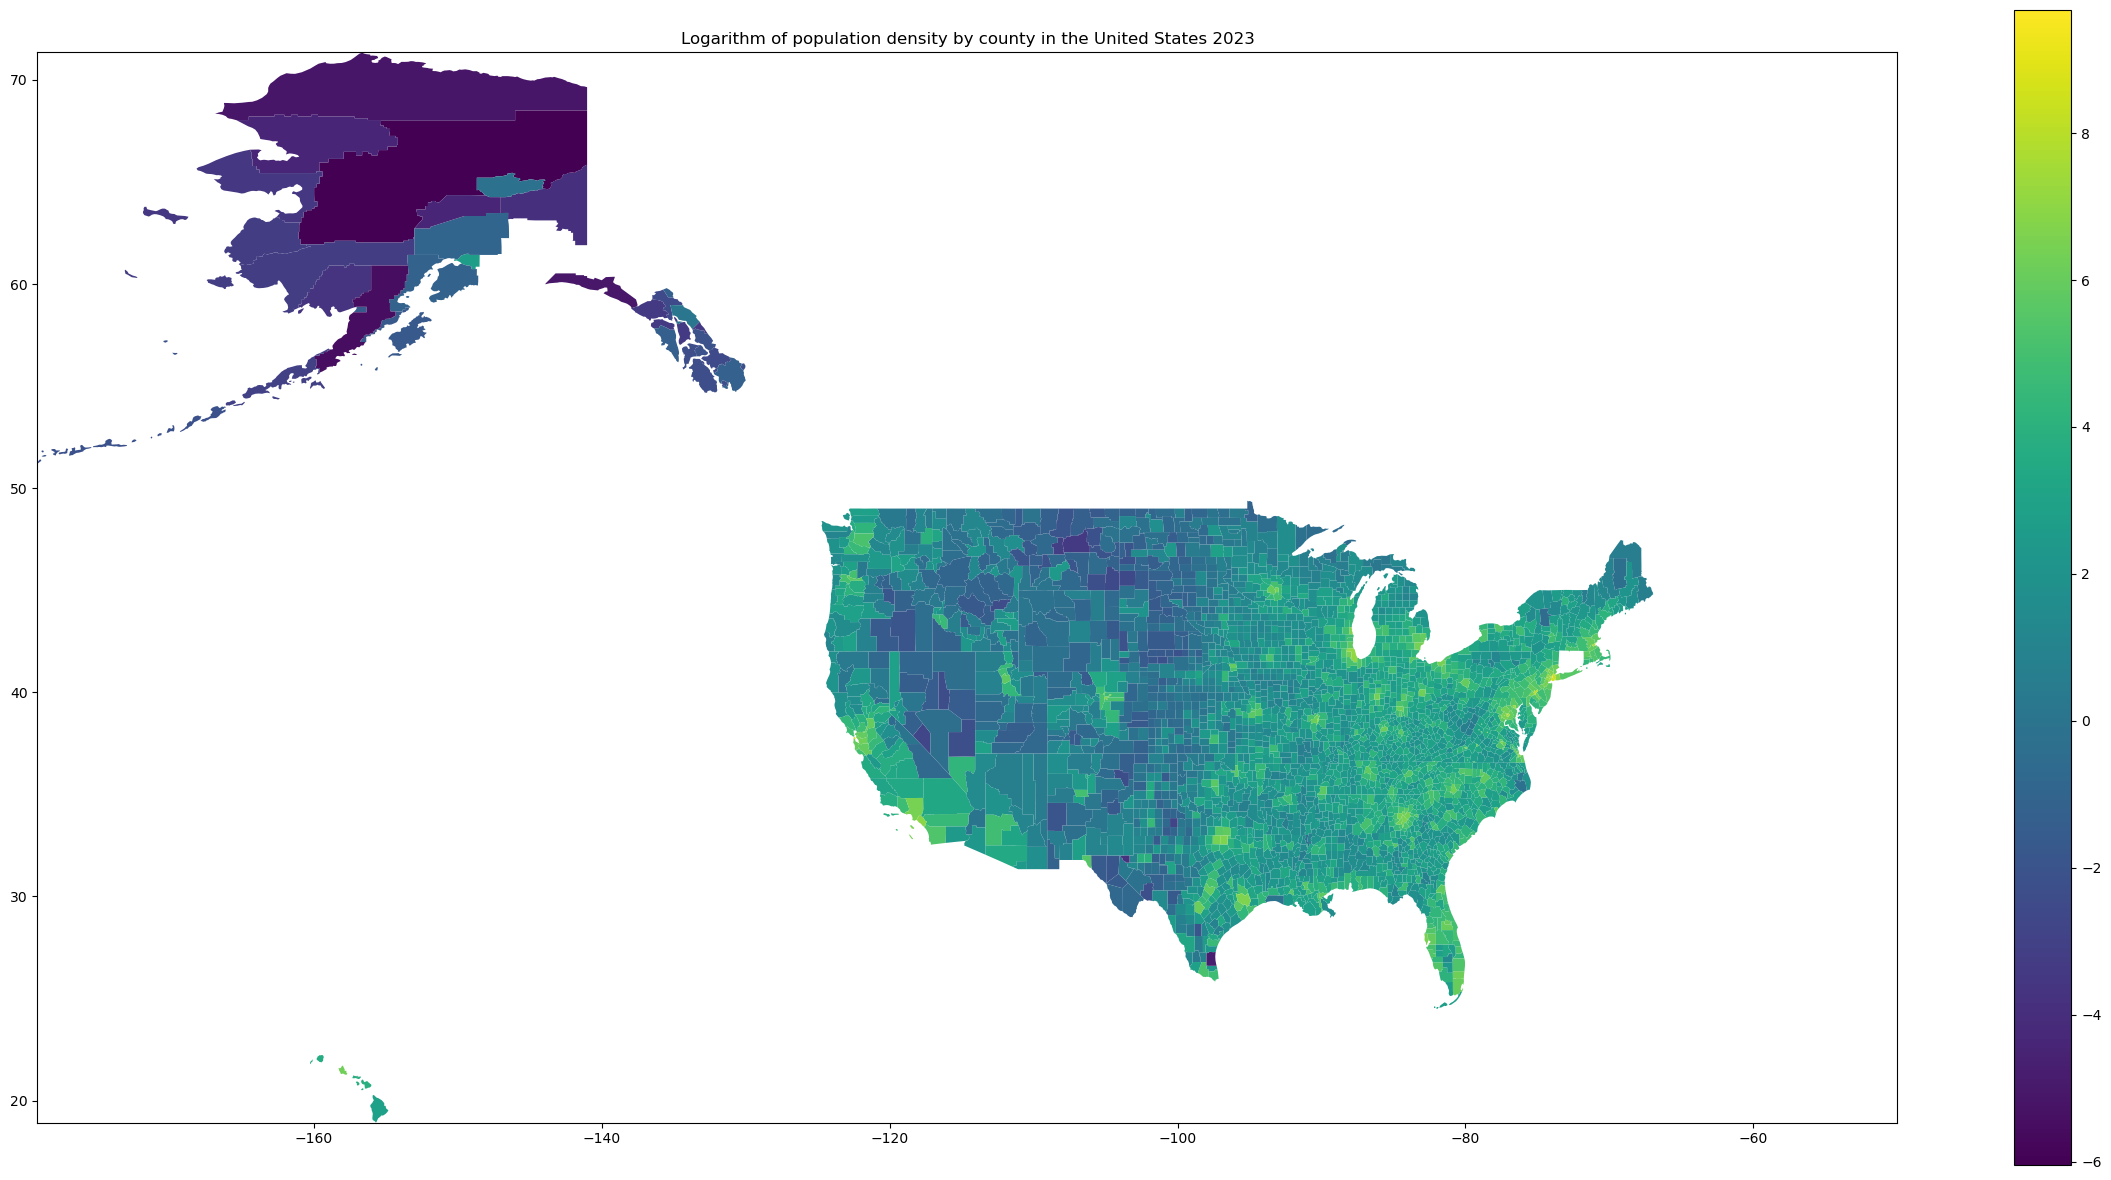

In [331]:
fig, ax = plt.subplots(figsize=(30,15))

minx, miny, maxx, maxy = plt_pop.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

# ax.set_xlim(-130, -60)
# ax.set_ylim(20, 50)

plt_pop.plot(ax=ax, column='log_pop_density', legend=True)
ax.set_title('Logarithm of population density by county in the United States 2023')
plt.show()

<a id='analysis'></a>
## Analysis

This section analyzes the relationship between 5G coverage and three socioeconomic factors -- median household income, education attainment, and population density. The analysis process includes 
   - merging datasets and dropping missing values
   - creating visualizations, specifically overlaying layers to study spatial relationships
   - running a regression analysis
   - interpretation of the result

<a id='5G-coverage-and-median-household-income'></a>
### Study the relationship between 5G coverage with median household income

In [91]:
# merge 5G availability data with median income data
plt_mb_income = plt_mb.merge(income, on='GEOID')
plt_mb_income.head()

,GEOID,geography_desc,geometry,5g_pct,NAME,income
0,37017,"Bladen, NC","POLYGON ((-78.90200 34.83527, -78.79960 34.850...",0.5394,"Bladen County, North Carolina",44528.0
1,37167,"Stanly, NC","POLYGON ((-80.49737 35.20210, -80.29542 35.502...",0.9249,"Stanly County, North Carolina",61631.0
2,39153,"Summit, OH","POLYGON ((-81.68699 41.13596, -81.68495 41.277...",1.0000,"Summit County, Ohio",71016.0
3,42113,"Sullivan, PA","POLYGON ((-76.81373 41.59003, -76.22014 41.541...",0.3278,"Sullivan County, Pennsylvania",64758.0
4,48459,"Upshur, TX","POLYGON ((-95.15274 32.66095, -95.15211 32.902...",0.7230,"Upshur County, Texas",62794.0


In [92]:
plt_mb_income[plt_mb_income.isna().any(axis=1)]

,GEOID,geography_desc,geometry,5g_pct,NAME,income
619,32009,"Esmeralda, NV","POLYGON ((-118.35148 37.89370, -117.69102 38.4...",0.3057,"Esmeralda County, Nevada",NaN
2303,48261,"Kenedy, TX","POLYGON ((-97.98589 27.20931, -97.81566 27.255...",0.3572,"Kenedy County, Texas",NaN


In [94]:
# drop NaN values
plt_mb_income = plt_mb_income.dropna()

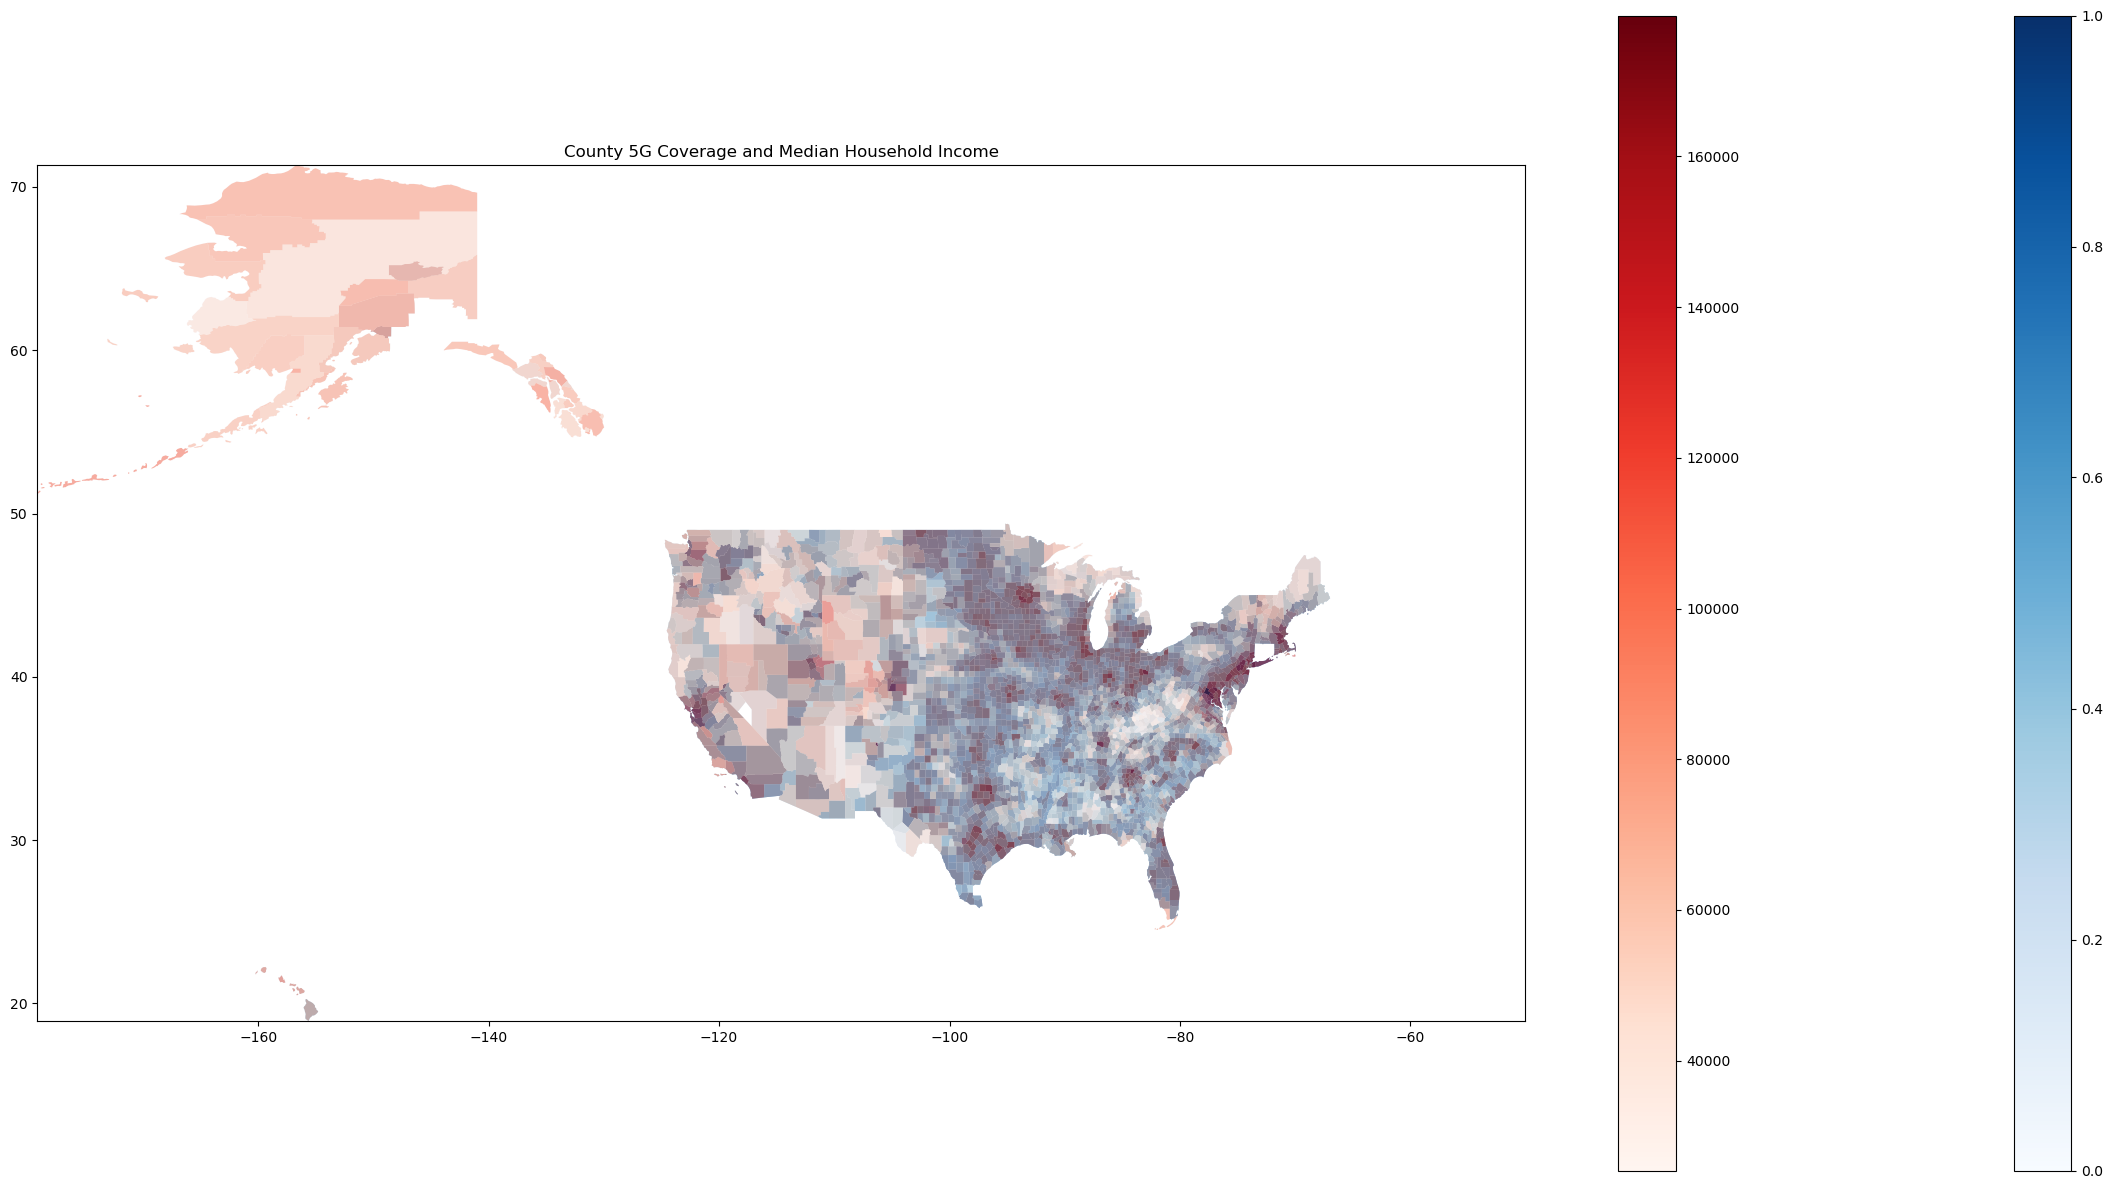

In [332]:
fig, ax = plt.subplots(figsize=(30, 15))
minx, miny, maxx, maxy = plt_mb_income.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

plt_mb_income.plot(ax=ax, column='5g_pct', cmap='Blues', legend=True)

# Overlay median household income with transparency
plt_mb_income.plot(ax=ax, column='income', cmap='Reds', alpha=0.5, legend=True)
plt.title('County 5G Coverage and Median Household Income')
plt.show()

In [366]:
# Run a regression analysis using statsmodels.api
X, y = plt_mb_income[['5g_pct']], plt_mb_income[['income']]

# add a constant term to include the intercept in the model
X = sm.add_constant(X)

# fit the OLS model
model = sm.OLS(y, X).fit()

# predict your with X
y_pred = model.predict(X)

# print the summary which includes coefficients, p-values, R-squared, etc.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     290.3
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.58e-62
Time:                        01:03:52   Log-Likelihood:                -34864.
No. Observations:                3131   AIC:                         6.973e+04
Df Residuals:                    3129   BIC:                         6.974e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.212e+04    866.041     60.183      0.000    5.04e+04    5.38e+04
5g_pct      2.052e+04   1204.205     17.037      0.000    1.82e+04    2.29e+04
==============================================================================
Omnibus:                      826.037   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2525.515
Skew:                           1.342   Prob(JB):                         0.00
Kurtosis:                       6.487   Cond. No.                         6.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

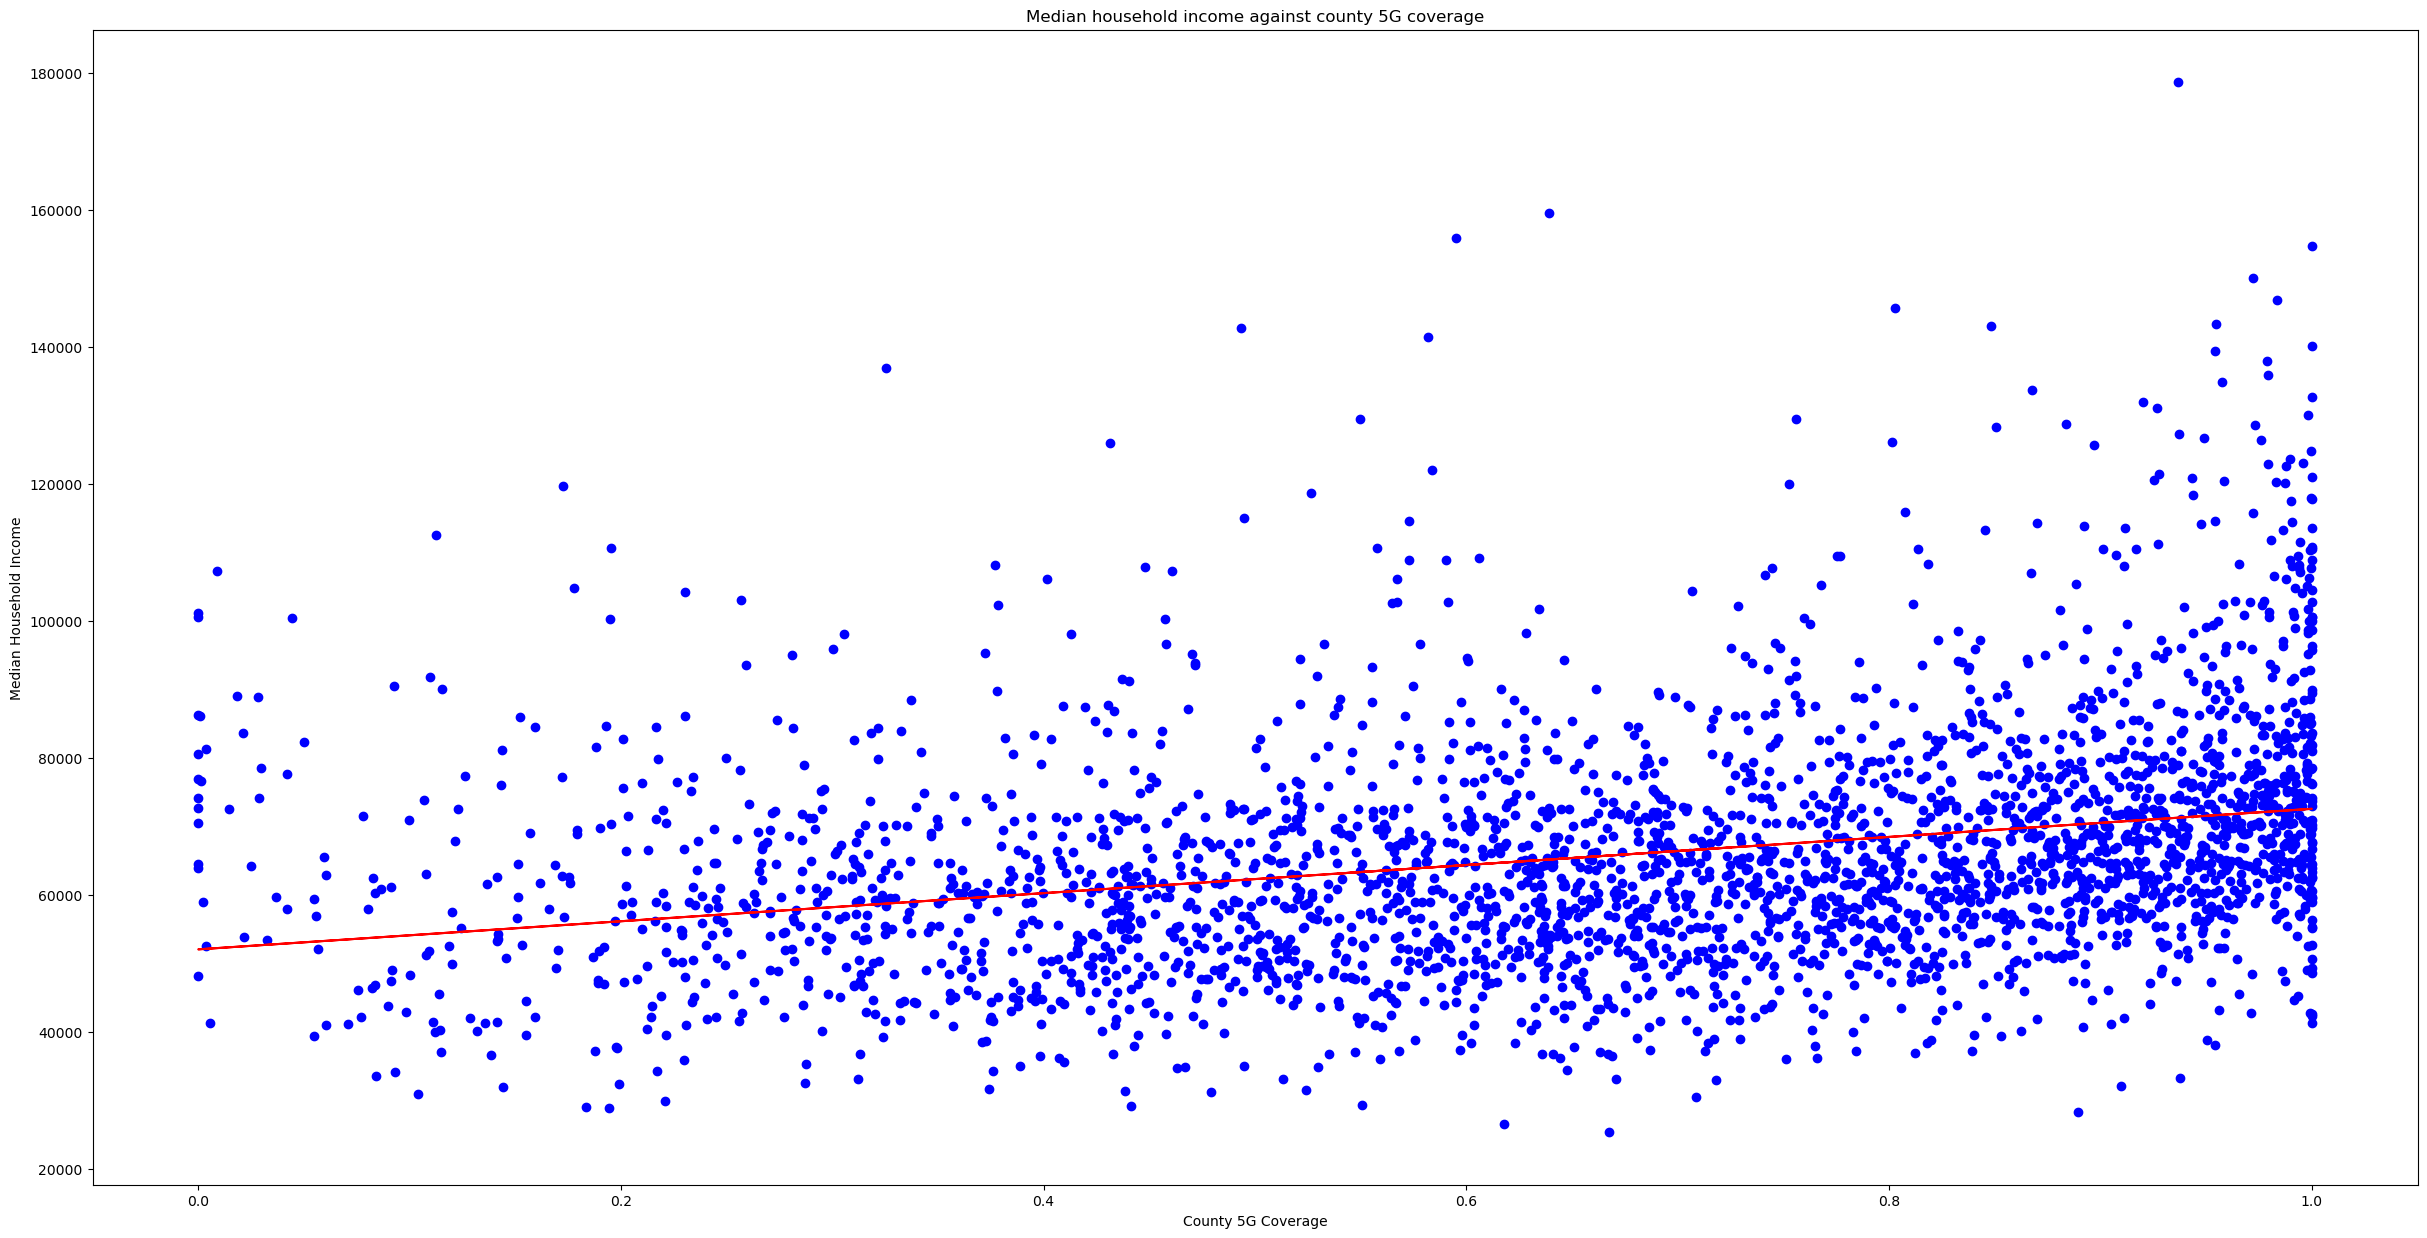

In [365]:
plt.figure(figsize=(30, 15))
plt.scatter(X['5g_pct'], y, color='blue')
plt.plot(X['5g_pct'], y_pred, color='red')
plt.xlabel('County 5G Coverage')
plt.ylabel('Median Household Income')
plt.title('Median household income against county 5G coverage')
plt.show()

#### Interpretation
In the map, counties with higher median household incomes (darker red shades) generally coincide with high 5G coverage (darker blue shades), suggesting that providers are focusing on economically prosperous areas. However, quite a big area of lower-income counties in the southeast region exhibit relatively good 5G coverage. This can be driven by other factors than income such as dense population centers. Higher income associated with higher 5G coverage indicates the role of economic factors in infrastructure deployment.

The regression equation is: `Median household income = 52120 + 20520 * 5G coverage percentage`. The p-value (<0.05) indicates that the relationship is statistically significant. The low R-squared (0.085) suggests that 5G coverage only explains about 9% of the variability in median household income. This means other factors are likely influencing income, and the relationship between 5G coverage and income is relatively weak.

<a id='5g-coverage-and-education-attainment'></a>
### Study the relationship between 5G coverage with education attainment

In [228]:
# merge 5G availability data with median income data
plt_mb_educ = plt_mb.merge(educ, on='GEOID')
plt_mb_educ.head()

,GEOID,geography_desc,geometry,5g_pct,NAME,bs25_pct
0,37017,"Bladen, NC","POLYGON ((-78.90200 34.83527, -78.79960 34.850...",0.5394,"Bladen County, North Carolina",20.6
1,37167,"Stanly, NC","POLYGON ((-80.49737 35.20210, -80.29542 35.502...",0.9249,"Stanly County, North Carolina",19.7
2,39153,"Summit, OH","POLYGON ((-81.68699 41.13596, -81.68495 41.277...",1.0000,"Summit County, Ohio",35.3
3,42113,"Sullivan, PA","POLYGON ((-76.81373 41.59003, -76.22014 41.541...",0.3278,"Sullivan County, Pennsylvania",19.7
4,48459,"Upshur, TX","POLYGON ((-95.15274 32.66095, -95.15211 32.902...",0.7230,"Upshur County, Texas",17.5


In [229]:
plt_mb_educ[plt_mb_educ.isna().any(axis=1)]

,GEOID,geography_desc,geometry,5g_pct,NAME,bs25_pct


In [230]:
# drop NaN values
plt_mb_educ = plt_mb_educ.dropna()

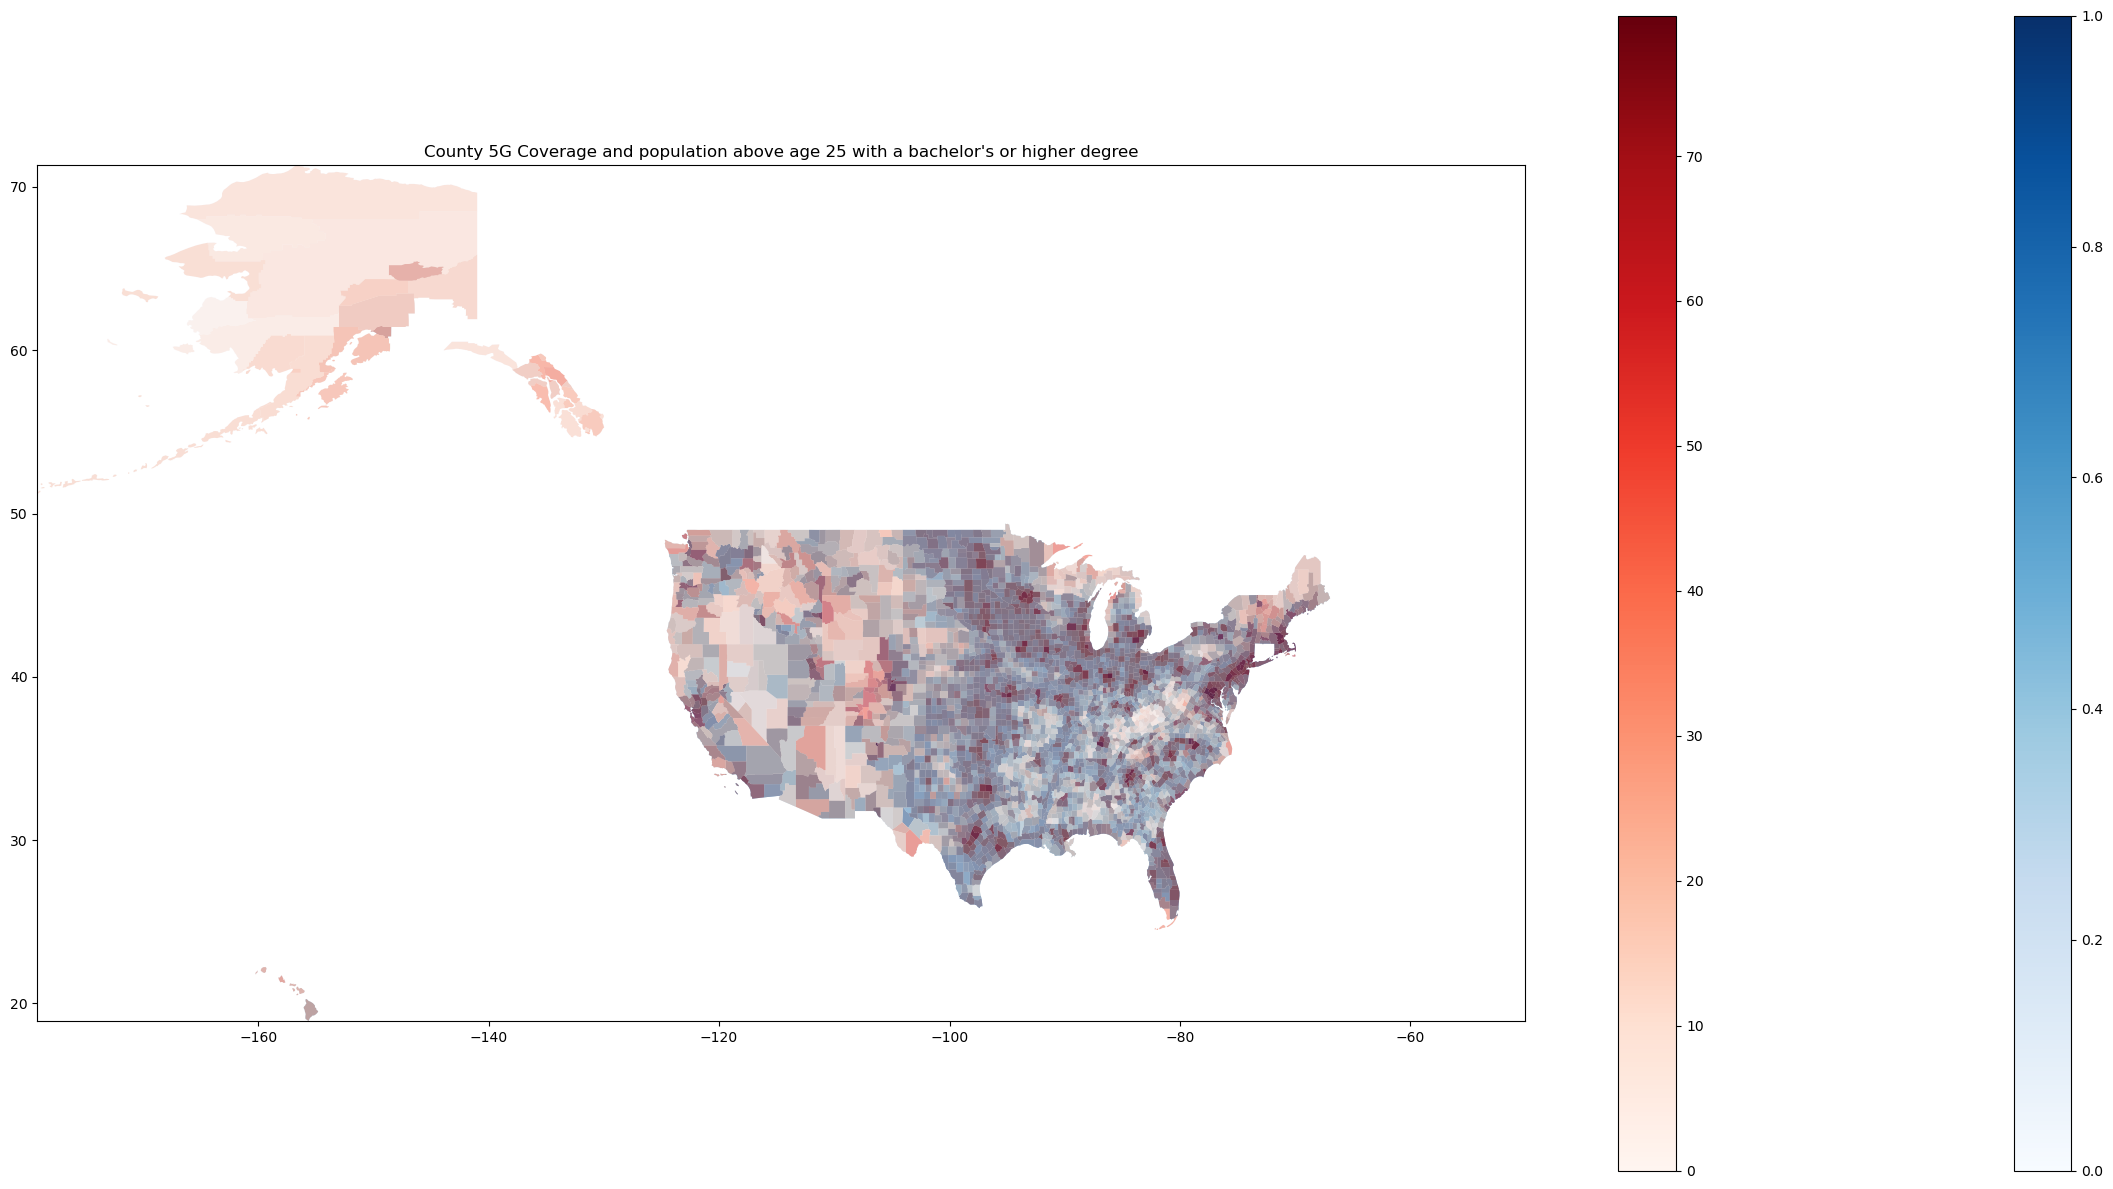

In [346]:
fig, ax = plt.subplots(figsize=(30, 15))
minx, miny, maxx, maxy = plt_mb_educ.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

plt_mb_educ.plot(ax=ax, column='5g_pct', cmap='Blues', legend=True)

# Overlay bs25_pct with transparency
plt_mb_educ.plot(ax=ax, column='bs25_pct', cmap='Reds', alpha=0.5, legend=True)
plt.title('County 5G Coverage and population above age 25 with a bachelor\'s or higher degree')
plt.show()

In [374]:
# Run a regression analysis using statsmodels.api
X, y = plt_mb_educ[['5g_pct']], plt_mb_educ[['bs25_pct']]

# add a constant term to include the intercept in the model
X = sm.add_constant(X)

# fit the OLS model
model = sm.OLS(y, X).fit()

# predict your with X
y_pred = model.predict(X)

# print the summary which includes coefficients, p-values, R-squared, etc.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               bs25_pct   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     157.6
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           2.58e-35
Time:                        02:44:25   Log-Likelihood:                -11632.
No. Observations:                3133   AIC:                         2.327e+04
Df Residuals:                    3131   BIC:                         2.328e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.9350      0.517     34.674      0.000      16.921      18.949
5g_pct         9.0326      0.719     12.556      0.000       7.622      10.443
==============================================================================
Omnibus:                      735.862   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1595.558
Skew:                           1.344   Prob(JB):                         0.00
Kurtosis:                       5.235   Cond. No.                         5.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

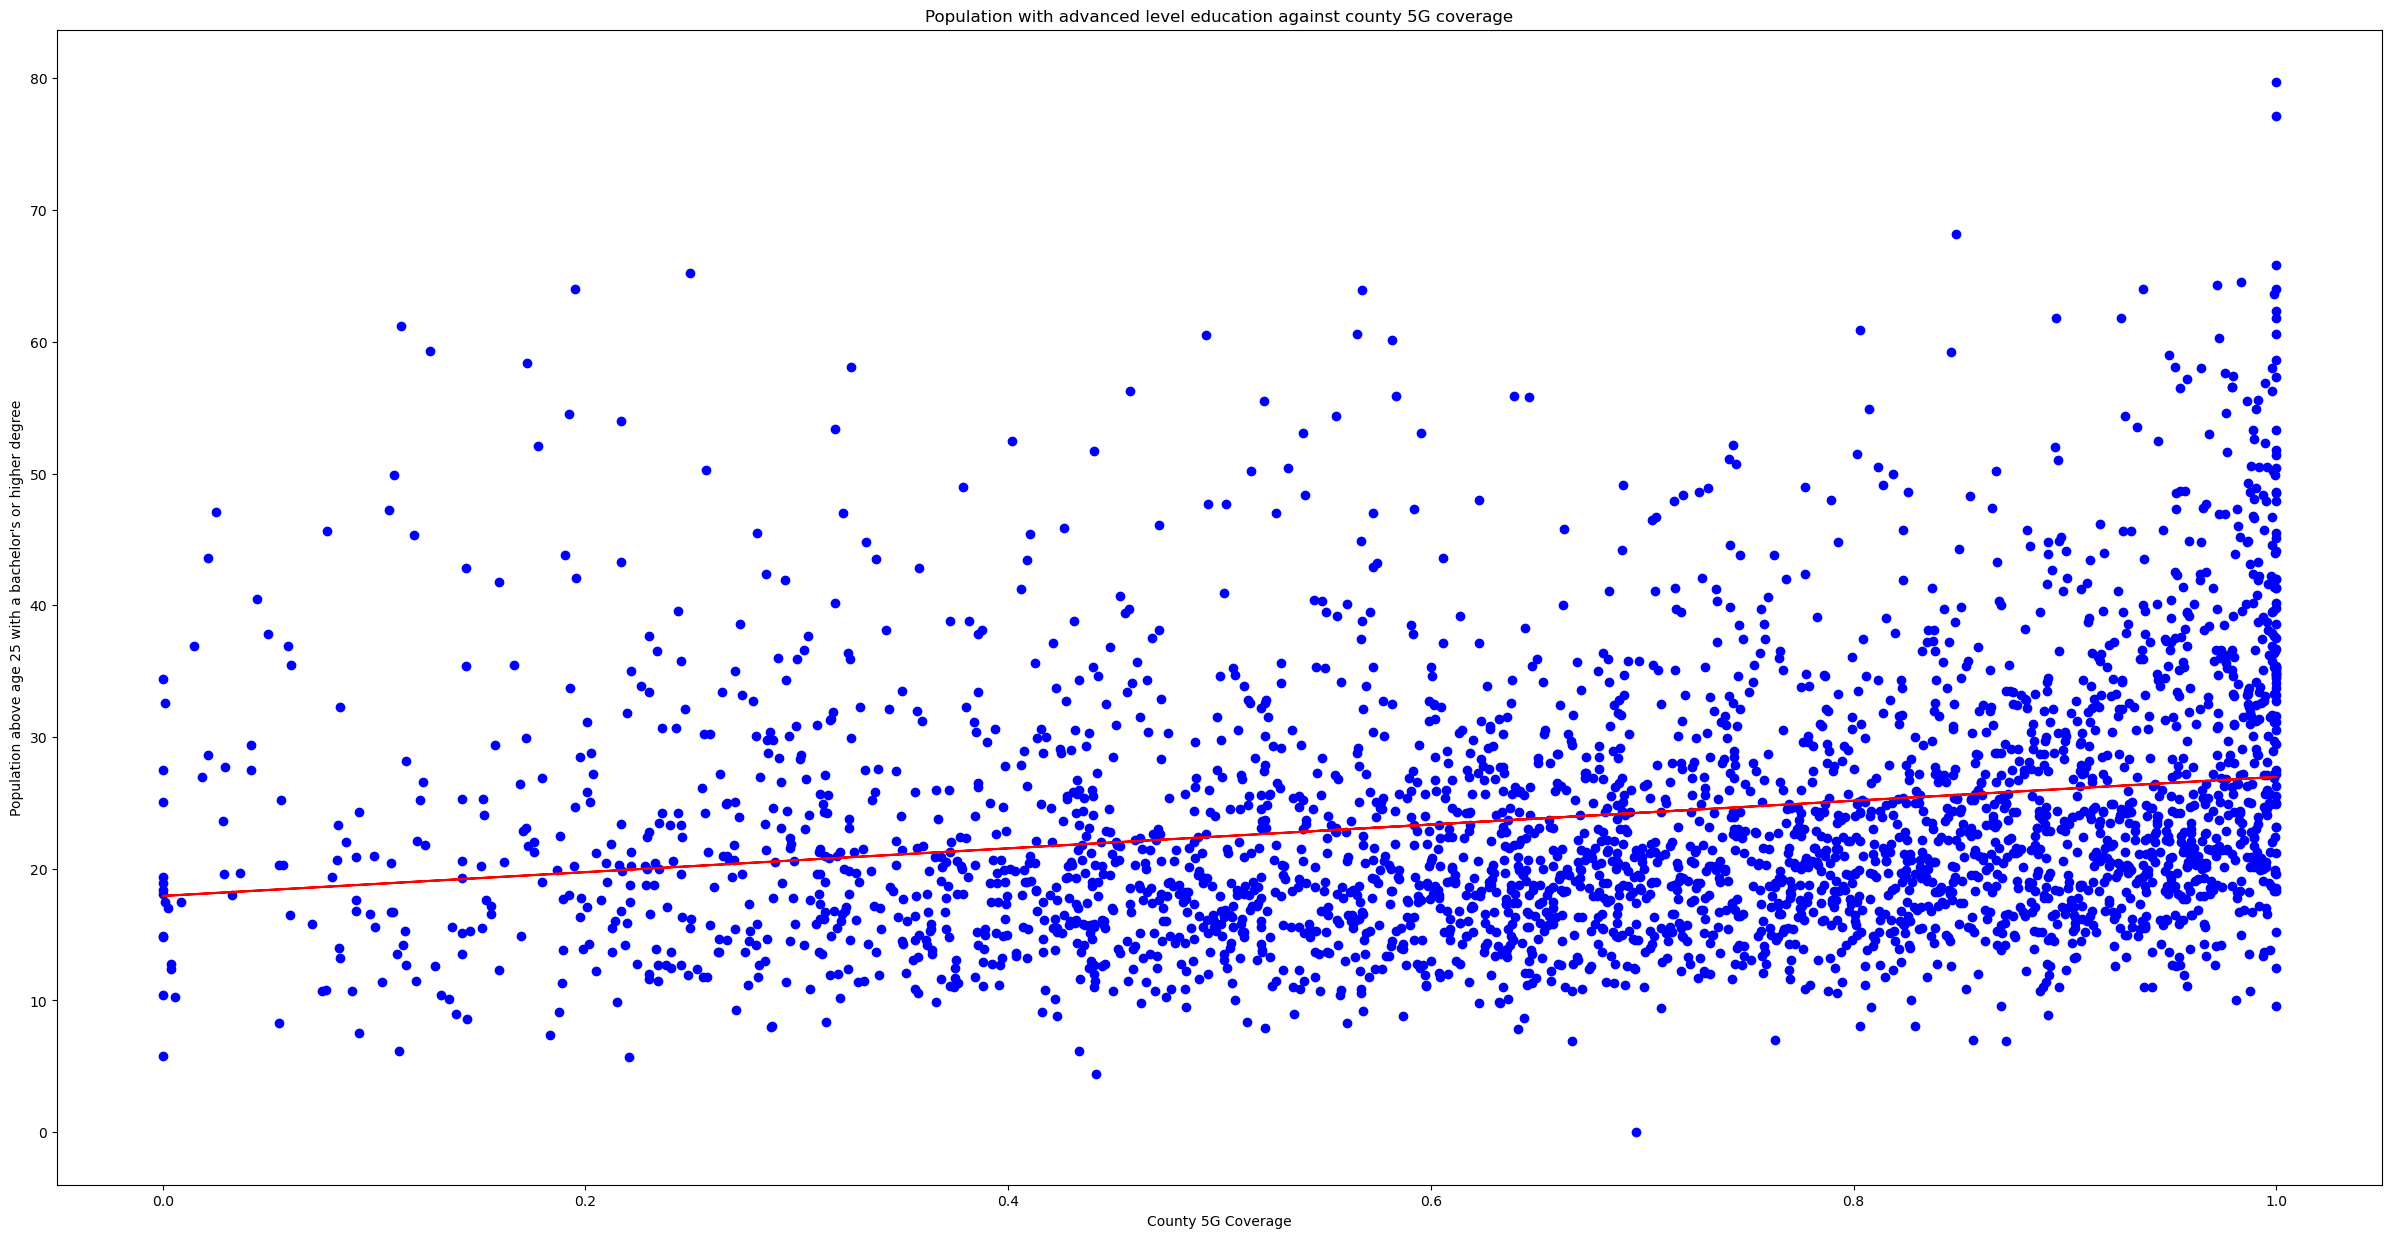

In [375]:
plt.figure(figsize=(30, 15))
plt.scatter(X['5g_pct'], y, color='blue')
plt.plot(X['5g_pct'], y_pred, color='red')
plt.xlabel('County 5G Coverage')
plt.ylabel('Population above age 25 with a bachelor\'s or higher degree')
plt.title('Population with advanced level education against county 5G coverage')
plt.show()

#### Interpretation
In the map, counties with bigger populations that obtain high-level education (darker red shades) are mostly clustered on the northeast, the midwest, and some parts of the south. Counties with high 5G coverage (darker blue shades) are also clustered in these areas (but not in the middle of the south), implying that better contemporary education is often associated with high 5G coverage. Nevertheless, high 5G coverage does not guarantee bigger populations attaining advanced level education. Similar to the first analysis, this can be driven by other factors such as dense population centers or economic centers. Larger populations with advanced education associated with higher 5G coverage indicates the role of infrastructure deployment in developing high-skilled human resources for the country.

The regression equation is: `Percentage of population above age 25 with advanced level education = 17.935 + 9.0326 * 5G coverage percentage`. The p-value (<0.05) indicates that the relationship is statistically significant. The low R-squared (0.048) suggests that 5G coverage only explains about 5% of the variability in high-level education attainment. This means other factors are likely influencing it, and the relationship between 5G coverage and high-level education within the population is relatively weak.

<a id='5g-coverage-and-population-density'></a>
### Study the relationship between 5G coverage with population density

In [206]:
# merge 5G availability data with population
plt_mb_educ = plt_mb.merge(pop, on='GEOID')

# reproject to a Cartesian system for area computation
plt_mb_pop = plt_mb_pop.to_crs(epsg=3857)
plt_mb_pop['area_km2'] = plt_mb_pop['geometry'].area / 1e6

# compute population density
plt_mb_pop['pop_density'] = plt_mb_pop['total_pop'] / plt_mb_pop['area_km2']

# compute log of population density because there are outliers (e.g. New Jersey) that dominates the color scale
plt_mb_pop['log_pop_density'] = np.log(plt_mb_pop['pop_density'])

# reproject
plt_mb_pop = plt_mb_pop.to_crs(epsg=4269)

plt_mb_pop.head()

,GEOID,geography_desc,geometry,5g_pct,NAME,total_pop,area_km2,pop_density,log_pop_density
0,37017,"Bladen, NC","POLYGON ((-78.90200 34.83527, -78.79960 34.850...",0.5394,"Bladen County, North Carolina",29591,3372.385314,8.774502,2.171850
1,37167,"Stanly, NC","POLYGON ((-80.49737 35.20210, -80.29542 35.502...",0.9249,"Stanly County, North Carolina",63557,1580.060242,40.224416,3.694474
2,39153,"Summit, OH","POLYGON ((-81.68699 41.13596, -81.68495 41.277...",1.0000,"Summit County, Ohio",538087,1935.847680,277.959369,5.627475
3,42113,"Sullivan, PA","POLYGON ((-76.81373 41.59003, -76.22014 41.541...",0.3278,"Sullivan County, Pennsylvania",5849,2088.492511,2.800585,1.029828
4,48459,"Upshur, TX","POLYGON ((-95.15274 32.66095, -95.15211 32.902...",0.7230,"Upshur County, Texas",41864,2165.593144,19.331424,2.961732


In [207]:
plt_mb_pop[plt_mb_pop.isna().any(axis=1)]

,GEOID,geography_desc,geometry,5g_pct,NAME,total_pop,area_km2,pop_density,log_pop_density


In [208]:
# drop NaN values
plt_mb_pop = plt_mb_pop.dropna()

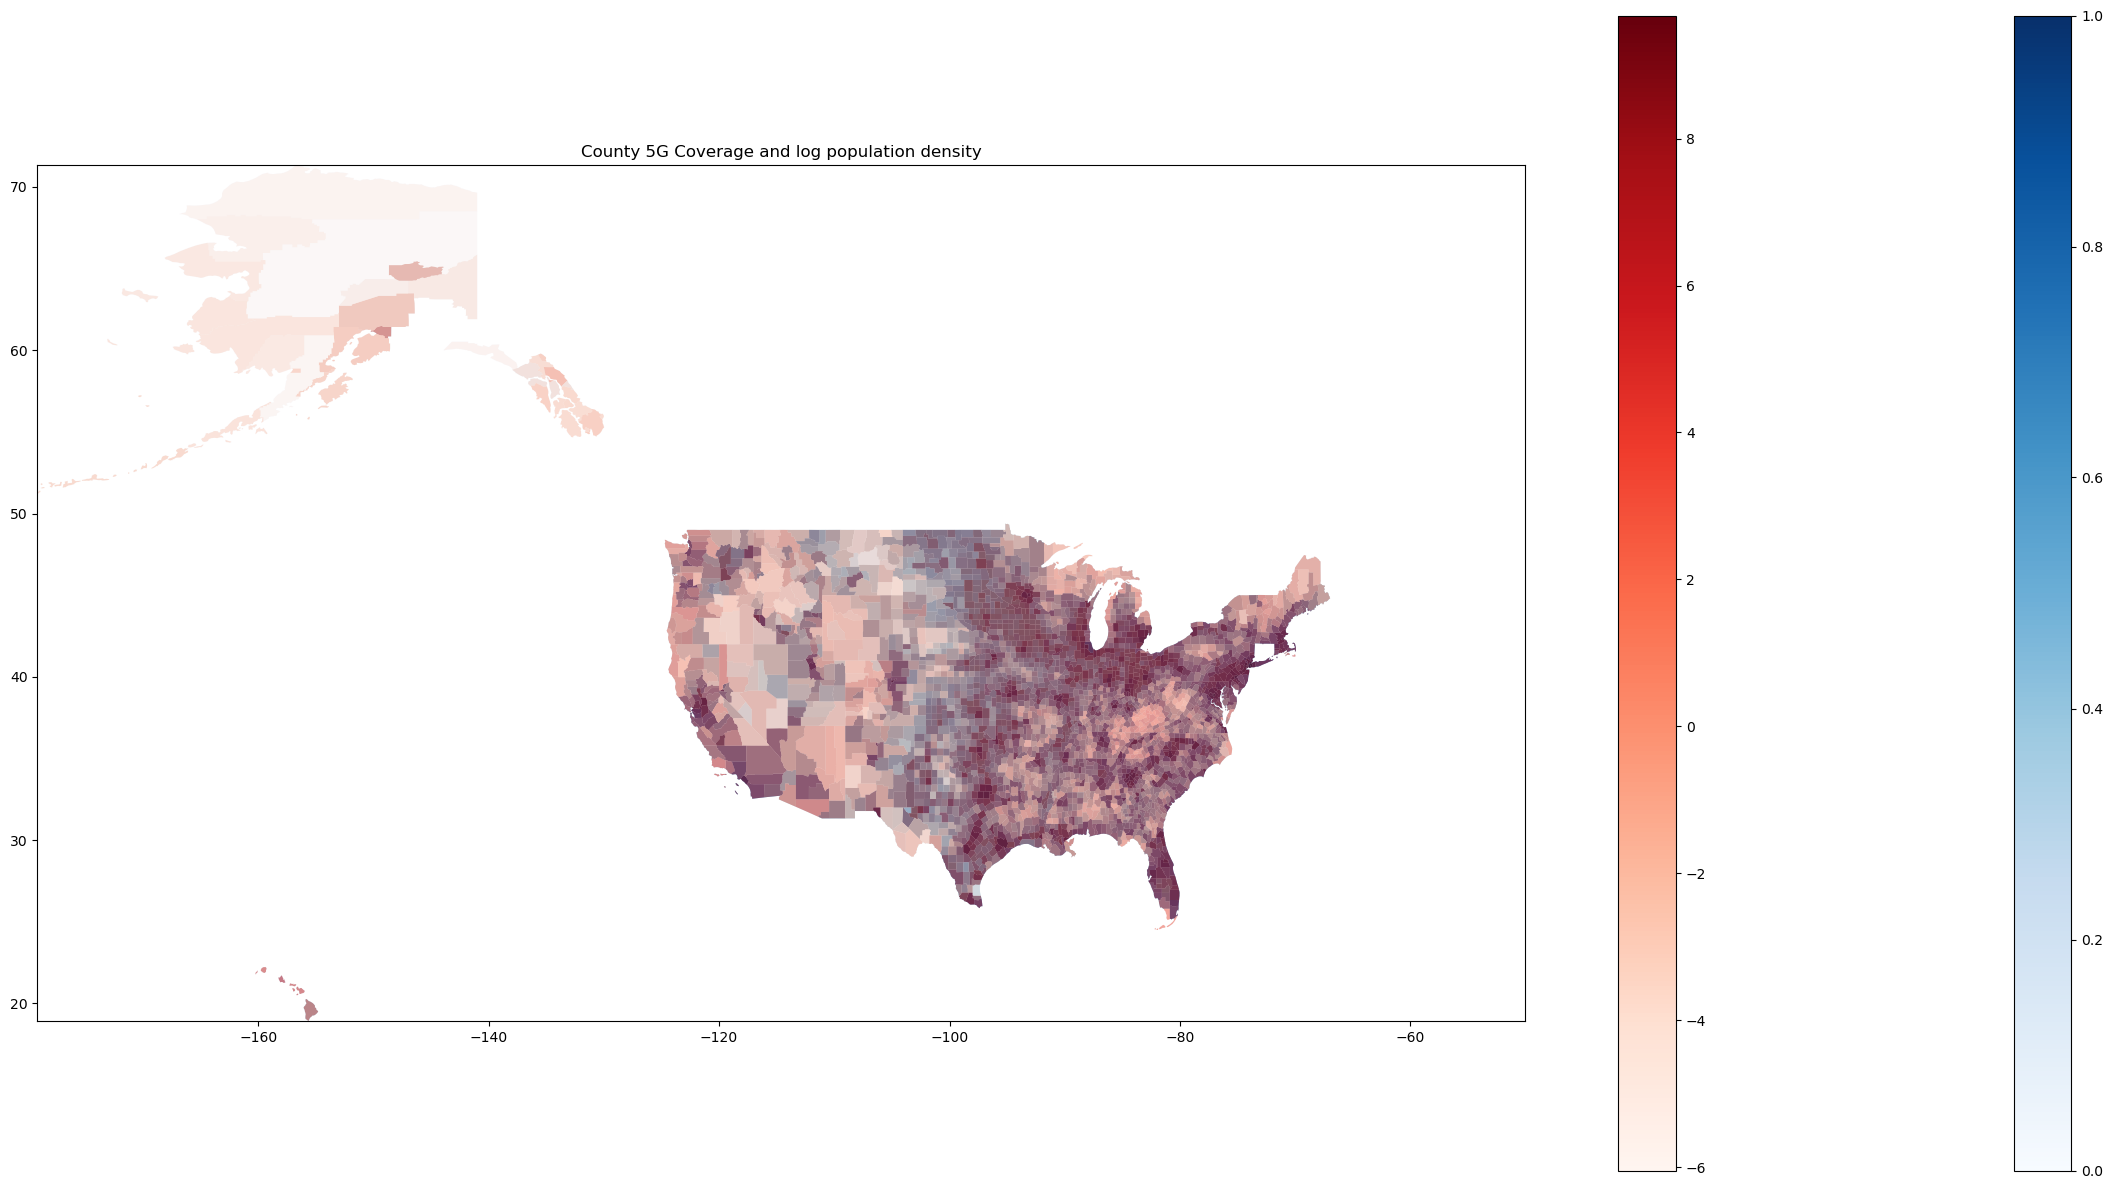

In [347]:
fig, ax = plt.subplots(figsize=(30, 15))
minx, miny, maxx, maxy = plt_mb_pop.geometry.total_bounds
ax.set_xlim(minx, -50) # remove small parts of Alaska on the far right for clearer visualization
ax.set_ylim(miny, maxy)

plt_mb_pop.plot(ax=ax, column='5g_pct', cmap='Blues', legend=True)

# Overlay bs25_pct with transparency
plt_mb_pop.plot(ax=ax, column='log_pop_density', cmap='Reds', alpha=0.5, legend=True)
plt.title('County 5G Coverage and log population density')
plt.show()

In [376]:
# Run a regression analysis using statsmodels.api
X, y = plt_mb_pop[['5g_pct']], plt_mb_pop[['log_pop_density']]

# add a constant term to include the intercept in the model
X = sm.add_constant(X)

# fit the OLS model
model = sm.OLS(y, X).fit()

# predict your with X
y_pred = model.predict(X)

# print the summary which includes coefficients, p-values, R-squared, etc.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        log_pop_density   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     1195.
Date:                Mon, 10 Mar 2025   Prob (F-statistic):          3.93e-222
Time:                        02:53:56   Log-Likelihood:                -5850.7
No. Observations:                3133   AIC:                         1.171e+04
Df Residuals:                    3131   BIC:                         1.172e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3651      0.082     -4.468      0.000      -0.525      -0.205
5g_pct         3.9287      0.114     34.572      0.000       3.706       4.151
==============================================================================
Omnibus:                       34.759   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.032
Skew:                          -0.229   Prob(JB):                     9.09e-09
Kurtosis:                       3.272   Cond. No.                         5.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

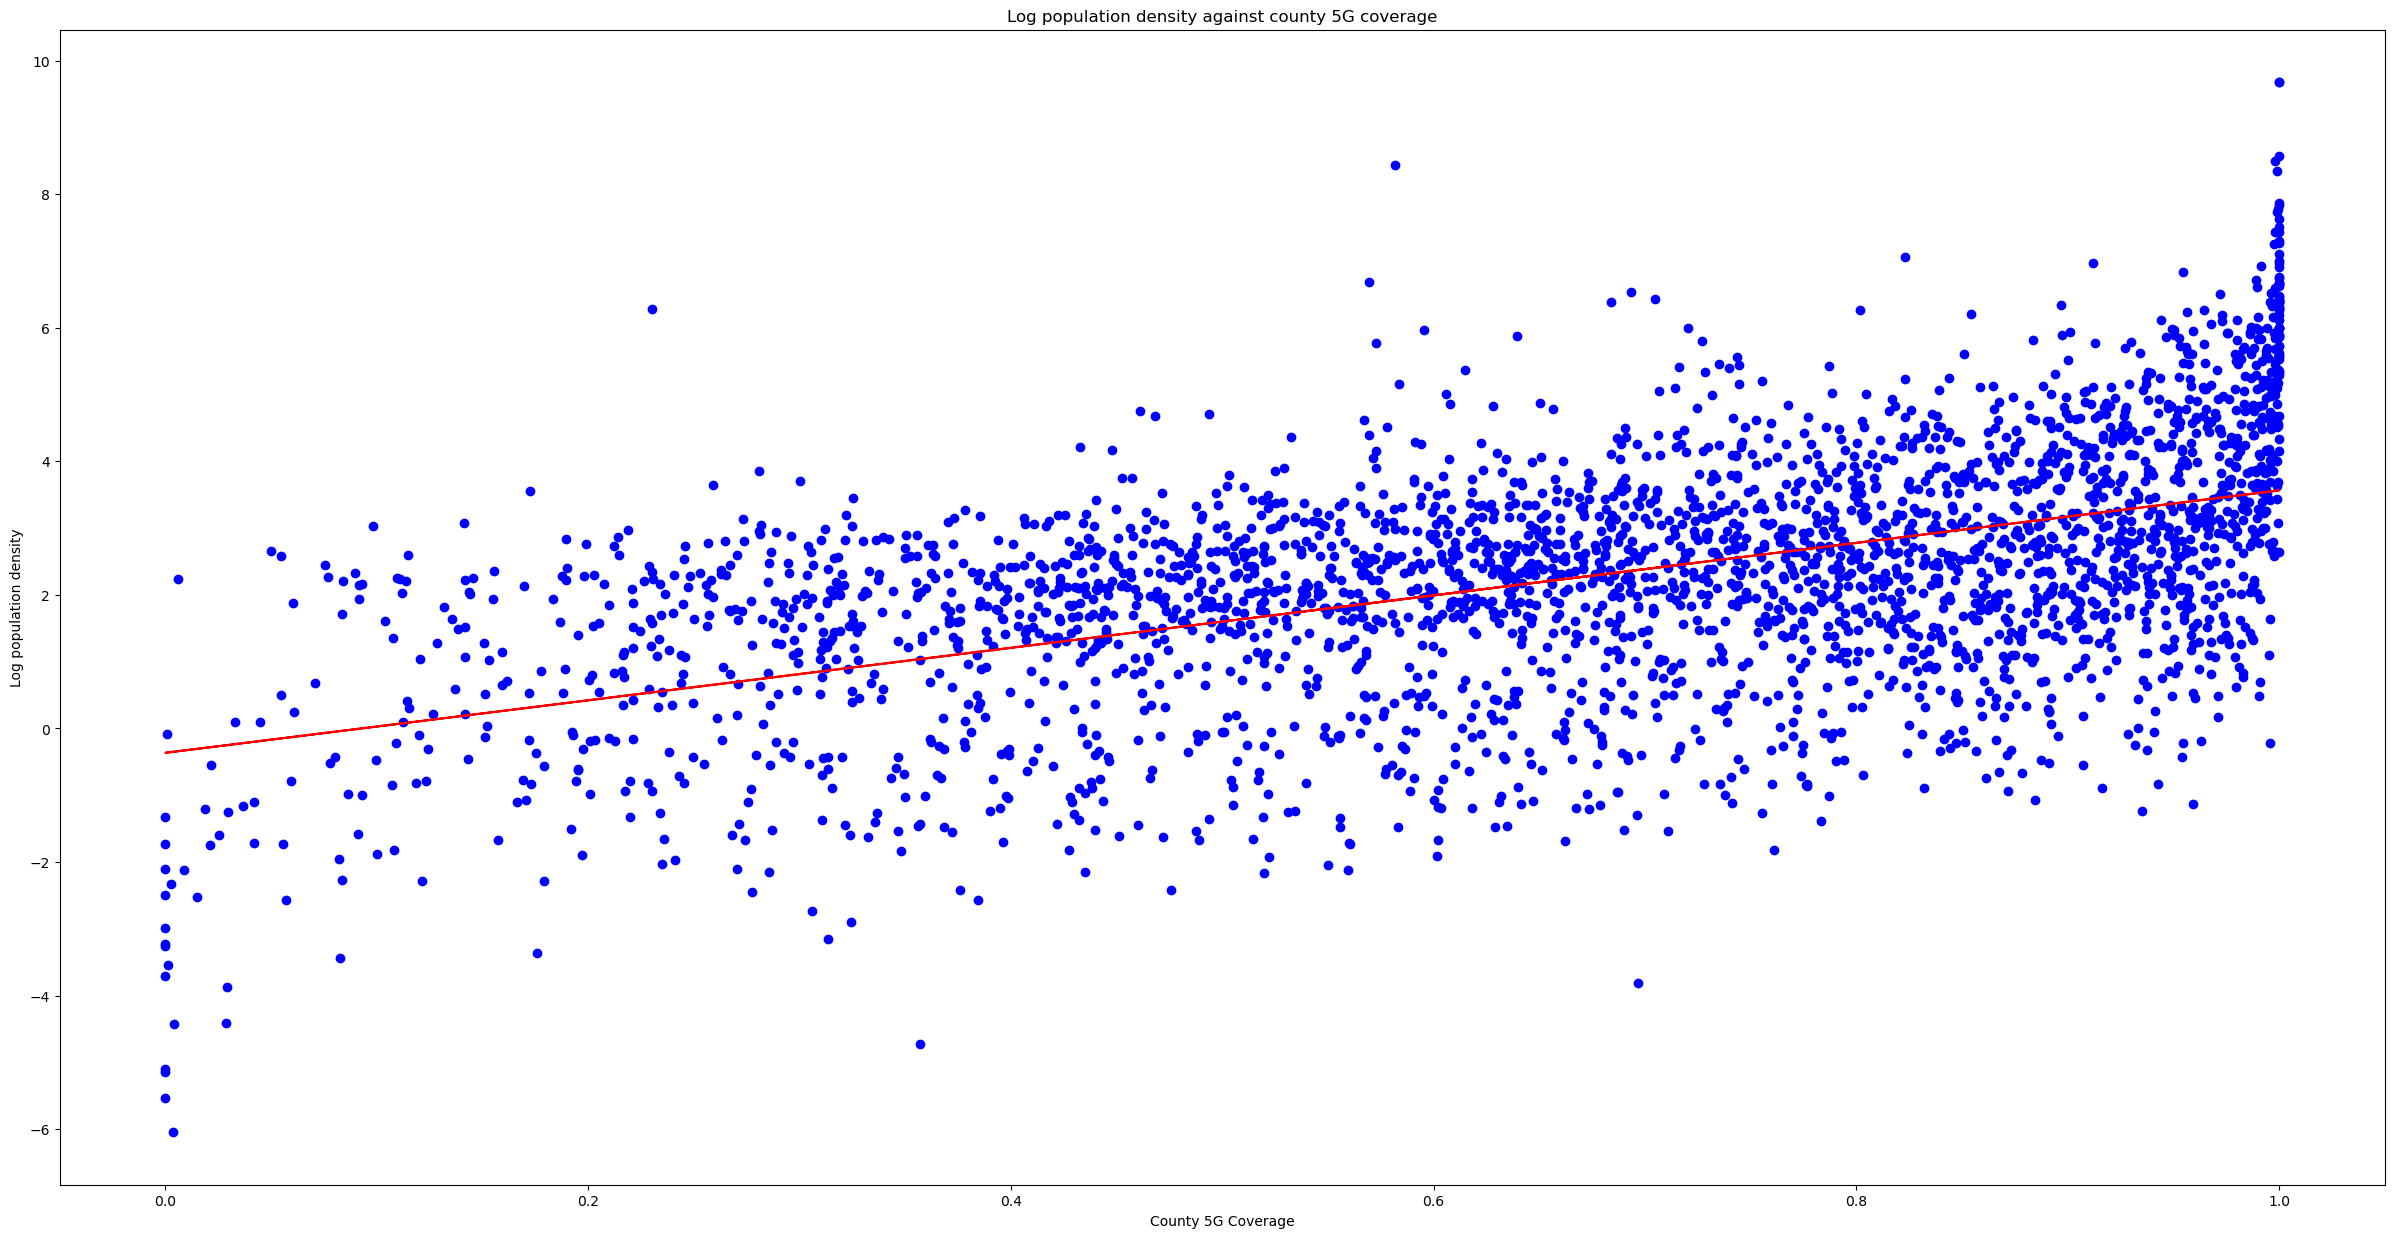

In [377]:
plt.figure(figsize=(30, 15))
plt.scatter(X['5g_pct'], y, color='blue')
plt.plot(X['5g_pct'], y_pred, color='red')
plt.xlabel('County 5G Coverage')
plt.ylabel('Log population density')
plt.title('Log population density against county 5G coverage')
plt.show()

#### Interpretation
The logarithm of population density instead of the population density is computed because there are outliers (e.g. New Jersey) that dominates the color scale. In the map, counties with higher log population density (darker red shades) are mostly clustered on the northeast, the midwest, the south, Washington and California. Counties with high 5G coverage (darker blue shades) are also clustered in these areas, implying that higher population density is often associated with high 5G coverage. 

The regression equation is: `Log (Population Density) = -0.3651 + 3.9287 * 5G coverage percentage`. The p-value (<0.05) indicates that the relationship is statistically significant. The R-squared (0.276) suggests that 5G coverage explains about 28% of the variability in log of population density. This number that occurred in social/economic studies implies that there is a correlation between 5G coverage and log population density, and it is worth further investigating on this relationship.

<a id='conclusion'></a>
## Conclusion

This section includes a summary of the analysis results, and the limitations of my work and some future works that can be researched to improve our understanding on the topic.

To conclude, we can now answer the initial research questions and determine whether the hypotheses are true or false.
1. <b>Question</b>: How does high-speed broadband coverage correlate with median income? <br/>
   <b>Hypothesis</b>: High-speed broadband coverage is highly and positively correlated with median income in a county. <br/>
   <b>Conclusion</b>: The hypothesis is false. The choropleth map might show some overlapping clusters which implies correlation, but according to the regression analysis, high-speed broadband is not highly correlated with median household income in a county.

2. <b>Question</b>: What is the relationship between education attainment and high-speed broadband coverage? <br/>
   <b>Hypothesis</b>: The higher the education attained by the population in a county, the higher the percentage of high-speed broadband coverage. <br/>
   <b>Conclusion</b>: The hypothesis is false. According to the regression analysis, bigger populations with higher education attainment does not associate with higher percentage of high-speed broadband coverage. Some counties with lower highly educated populations also have access to 5G services.
   
3. <b>Question</b>: Is there a correlation population density and broadband coverage? <br/>
   <b>Hypothesis</b>: Yes, population density in a county is highly and positively correlated with broadband coverage. <br/>
   <b>Conclusion</b>: The hypothesis is true. According to the log-linear regression model, population density in a county is highly and positively correlated with its broadband coverage.

<b>Personal thoughts about the results</b> <br>
Personally, I found the results of the analysis quite unexpected when two of my hypotheses were proved to be false. I thought that socioeconomic factors can be strongly correlated with the digital development of a region, but the analysis shows that it might not be the case. However, there could be other reasons explaining the results. For instance, there might be a lag in the improvement of income and education in some areas with more recently built 5G infrastructure. But, I would like to clarify that this is a project that studies only the correlations between these variables, rather than causations, so the reasons might not be valid.

<b>Limitations</b> <br>
There are definitely limitations to my work. For example, all the variables used in this project are aggregated at the county level. This aggregation can mask intra-county differences, leading to an overgeneralized picture of broadband coverage within each region. Also, by only conducting simple regressions, I have not accounted for spatial autocorrelations, where observations in neighboring counties may be more similar to each other than counties that are far apart.

<b>Future work</b> <br>
If data is available, we can use smaller geographic units for the variables in this project such as neighborhoods. Accounting for spatial autocorrelations, models such as spatial autoregressive can be used. The analysis is conducted with only dataset of a single year which makes it quite limited to discover more interesting patterns. Tracking 5G coverage and socioeconomic variables over multiple years might show trends and allow us to observe how these variables grow over time.